## What is delta?

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torch
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from torch.optim import Optimizer
import math
import torchvision.transforms as transforms
import torchvision
import os
from torch.autograd import Variable


In [2]:
class MY(Optimizer):
    r"""Implements Adam and SGD mix algorithm.
    """

    def __init__(self,
                 params,
                 lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,SGD_weight = 0.5, Adam_weight = 0.8, opPrint = True):    
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,Adam_weight = Adam_weight, SGD_weight = SGD_weight,
            phase = 'ADAM', SGD_lr = 0.01
        )
        super(MY, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(MY, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self ,current_epoch, No_epoch, adam_phase, mix_phase, Mix_batch_count,opPrint = True, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        #print("MY")
        #print(Mix_batch_count)
        inc_list = np.linspace(0,1,round(mix_phase*No_epoch))
        #print(inc_list)
        #inc_list = np.logspace(np.log10(0.01), np.log10(1), int((adam_phase*No_epoch + mix_phase*No_epoch)-adam_phase*No_epoch))

        for group in self.param_groups:
            
            if current_epoch <= adam_phase*No_epoch:
                
                group['phase'] = "ADAM"
                if opPrint == True:
                    print("ADAM | Current epoch = ",current_epoch)


            elif adam_phase*No_epoch < current_epoch <= (adam_phase*No_epoch + mix_phase*No_epoch):

                group['phase'] = 'MIX'
                group['Adam_weight'] = 1-inc_list[Mix_batch_count]
                group['SGD_weight'] = inc_list[Mix_batch_count]
                
                if opPrint == True:
                    print("\nMix batch count = ", Mix_batch_count)
                    print("\nMIX | Current epoch = ",current_epoch)
                    print("MIX | SGD Weight = ",group['SGD_weight'])
                    print("MIX | Adam Weight = ",group['Adam_weight'])

            else:
                group['phase'] = 'SGD'
                if opPrint == True:
                    print("SGD | Current epoch = ",current_epoch)
            
            for p in group['params']:

                if p.grad is None:
                    continue
                    
                grad = p.grad   
                state = self.state[p]

                if group['phase'] == 'SGD':
                    #print('SGD')
                    
                    d_p_sgd = self.sgd_step(grad, group, p)
                    
                    p.add_(d_p_sgd, alpha=-abs(group['SGD_lr']).item())
                    
                    continue
                
                if group['phase'] == 'ADAM':
                    #print("The phase is now ADAM")
                    d_p_adam, step_size,exp_avg2, bias_correction2, state['diff'] = self.adam_step(grad, group, p)
                    
                    w = d_p_adam*step_size*-1
                    p.data.add_(w)
                    
                    
                if group['phase'] == 'MIX':
                    #print("The phase is now MIX")
                    
                    d_p_adam, step_size, exp_avg2, bias_correction2, state['diff']  = self.adam_step(grad, group, p)
                    
                    w = d_p_adam*step_size*-1

                    d_p_sgd = self.sgd_step(grad, group, p)
                    
                    megred_d_p = group['SGD_weight'] * d_p_sgd + group['Adam_weight'] * d_p_adam
            
                    merged_lr = group['SGD_weight'] * abs(group['SGD_lr']) + group['Adam_weight'] * step_size

                    p.add_(megred_d_p, alpha=-merged_lr.item())
                            
                
                
                #print("len of grad and p =", len(grad.view(-1)), len(w.view(-1)))
                p_view = w.view(-1)
                pg = p_view.dot(grad.view(-1))
                beta1, beta2 = group['betas']

                
                # the non-orthognal scaling estimate
                scaling = p_view.dot(p_view) / -pg
                exp_avg2.mul_(beta2).add_(scaling, alpha=1 - beta2)

                # bias corrected exponential average
                corrected_exp_avg = exp_avg2 / bias_correction2
                #print(current_epoch)
                
                
                if current_epoch > adam_phase*No_epoch:        
                    group['SGD_lr'] = corrected_exp_avg
                    print("Maws switch at", current_epoch)
                    print("MAWS SGD_LR = ", abs(group['SGD_lr']))
                    
        
        checker = group['phase']
        return loss,checker
        
               
    def check(self, group):
        if group == 'MIX':
            return True


    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            #state['SGD_lr'] = 0.01
            state['diff'] = 10.0
            state['exp_avg2'] = p.new(1).fill_(0)
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'].item())
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size, state['exp_avg2'], bias_correction2, state['diff']

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay.item())
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum.item())
            else:
                d_p = buf

        return d_p

In [3]:
from IPython.display import HTML
import random
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [4]:
class SWATS(Optimizer):
    r"""Implements Adam and SGD mix algorithm.
    """

    def __init__(self,
                 params, tolerance = 0.001, lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,
                 adam_w=0.5, sgd_w=0.5):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(tolerance = tolerance,
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,
            adam_w=adam_w, sgd_w=sgd_w, phase = 'ADAM'
        )
        super(SWATS, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SWATS, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self,epochs, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        difference = []
        corrected = []
        sca = []
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]

                
                
                    
                if group['phase'] == 'SGD':
                    
                    d_p_sgd = self.sgd_step(grad, group, p)
                    p.data.add_(-d_p_sgd * group['lr'])
                    continue
                    
                #print("The phase is now ADAM")
                d_p_adam, step_size,exp_avg2, bias_correction2, state['diff'] = self.adam_step(grad, group, p)
                    
                w = d_p_adam*step_size*-1
                p.data.add_(w)
                    
                
                #print("len of grad and p =", len(grad.view(-1)), len(w.view(-1)))
                p_view = w.view(-1)
                pg = p_view.dot(grad.view(-1))
                beta1, beta2 = group['betas']

                if pg != 0:
                    # the non-orthognal scaling estimate
                    scaling = p_view.dot(p_view) / -pg
                    exp_avg2.mul_(beta2).add_(scaling, alpha=1 - beta2)

                    # bias corrected exponential average
                    corrected_exp_avg = exp_avg2 / bias_correction2
                    
                    difference.append(corrected_exp_avg.item() - scaling.item())
                    corrected.append(corrected_exp_avg.item())
                    sca.append(scaling.item())
                    
                    state['diff'] = abs(corrected_exp_avg.item() - scaling.item())
                    
                    #state['diff'] < group['tolerance'] and corrected_exp_avg > 0
                    if (state['step'] == group['adam_w']):
                        print("SWATS switch happened at epoch ", epochs)
                        print(" SWATS lr after switch = ",corrected_exp_avg.item())
                        group['lr'] = corrected_exp_avg.item()
                        
                        group['phase'] = 'SGD'
                        
                        
                

                    
    

        return loss,difference, corrected, sca

    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            #state['SGD_lr'] = 0.01
            state['diff'] = 10.0
            state['exp_avg2'] = p.new(1).fill_(0)
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size, state['exp_avg2'], bias_correction2, state['diff']

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p

In [5]:
class SGD(Optimizer):
    r"""Implements SGDW algorithm.
    It has been proposed in `Decoupled Weight Decay Regularization`__.
    Arguments:
        params: iterable of parameters to optimize or dicts defining
            parameter groups
        lr: learning rate (default: 1e-3)
        momentum: momentum factor (default: 0)
        weight_decay: weight decay (L2 penalty) (default: 0)
        dampening: dampening for momentum (default: 0)
        nesterov: enables Nesterov momentum (default: False)
    Example:
        >>> import torch_optimizer as optim
        >>> optimizer = optim.SGDW(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ https://arxiv.org/abs/1711.05101
    Note:
        Reference code: https://github.com/pytorch/pytorch/pull/22466
    """

    def __init__(
        self,
        params,
        lr,
        momentum=0.9,
        dampening=0,
        weight_decay=0,
        nesterov = False
    ):

        defaults = dict(
            lr=lr,
            momentum=momentum,
            dampening=dampening,
            weight_decay=weight_decay,
            nesterov=nesterov,
        )

        
    def step(self,epochs):
        """Performs a single optimization step.
        Arguments:
            closure: A closure that reevaluates the model and returns the loss.
        """
        loss = None


        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data


                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(
                            d_p
                        ).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                # Apply momentum
                print(epochs)

                p.data.add_(d_p, alpha=-group['lr'])

                # Apply weight decay
                if weight_decay != 0:
                    p.data.add_(weight_decay, alpha=-group['lr'])
        return loss



#### Adabound

In [6]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## GD plotting of simple functions
#### Note you must choose the function to do the toy example on 

SWATS switch happened at epoch  4
 SWATS lr after switch =  0.007948698475956917
Maws switch at 9
MAWS SGD_LR =  tensor([0.0019])
Maws switch at 9
MAWS SGD_LR =  tensor([4.1975e-05])
Maws switch at 10
MAWS SGD_LR =  tensor([0.0017])
Maws switch at 10
MAWS SGD_LR =  tensor([3.9464e-05])
Maws switch at 11
MAWS SGD_LR =  tensor([0.0016])
Maws switch at 11
MAWS SGD_LR =  tensor([2.7764e-05])
Maws switch at 12
MAWS SGD_LR =  tensor([0.0015])
Maws switch at 12
MAWS SGD_LR =  tensor([0.0002])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:363: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


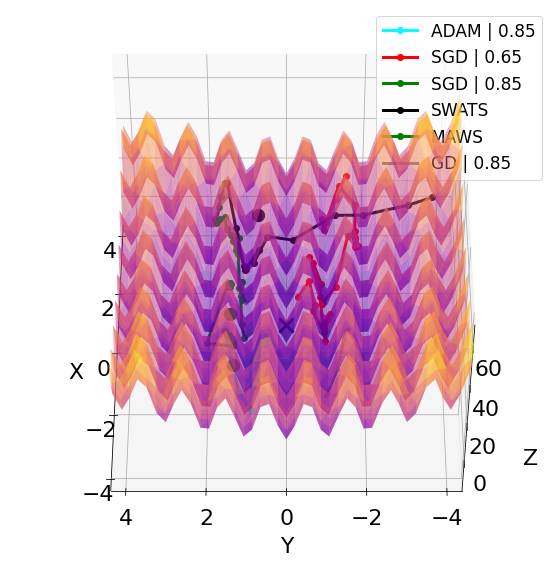

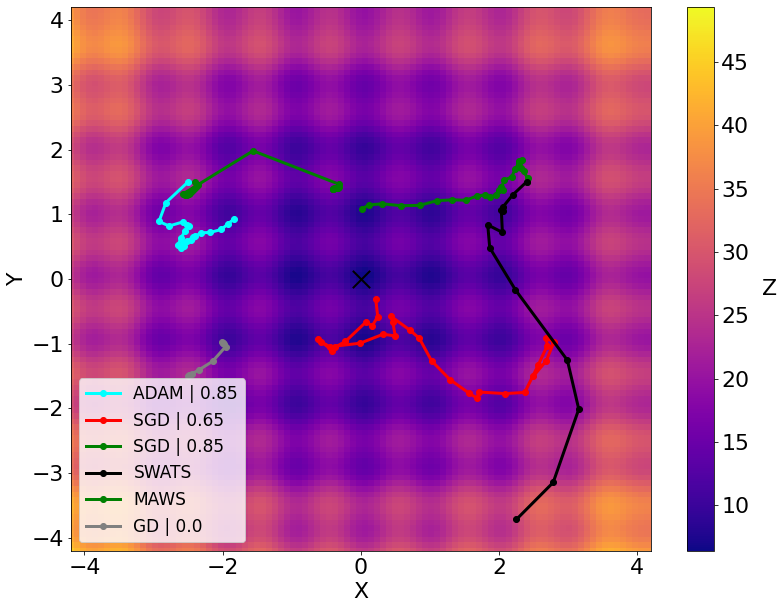

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d


import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.ma import arange
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from torch.optim import SGD, Adam


import random
seed_everything(1234)


def sad(w1,w2,a,b):
    return (w1-a)**2 - (w2-b)**2


def Ras(w1,w2,a,b):
    pi = torch.tensor(np.pi)
    a = torch.tensor(a)
    b = torch.tensor(b)    
    
    return torch.tensor(10.) + ((w1-a)**2 - torch.tensor(10.)*torch.cos(torch.tensor(2.)*pi*(w1-a)))+((w2-b)**2 - torch.tensor(10.)*torch.cos(torch.tensor(2.)*pi*(w2-b)))
    
def simple(w1,w2,a,b):
    a = torch.tensor(a)
    b = torch.tensor(b)
    c = torch.tensor(1/10.)
    return torch.abs((w1-a)**2)*c + torch.abs(w2-b)


minimums = {
    str(sad): (0, 0, 0),
    str(Ras):(0,0,0),
    str(simple):(0,0,0)   
}

def testOptimizer(optimizer, w1, w2, epochs, title, fu=simple, plots = True,adam_phase = 0.3, mix_phase = 0.15):
    points_x = []
    points_y = []
    points_z = []
    
    co_mix = []
    coend_mix = []
 
    losss = []

    if title == "SGD" or title == "SGDD":
        np.random.seed(1)
        a = np.random.normal(loc = 0.0, scale = 3, size = epochs)
        a = np.append(a,-sum(a))

        np.random.seed(2)
        b = np.random.normal(loc = 0.0, scale = 3, size = epochs)
        b = np.append(b,-sum(b))
        
        


    else:
        np.random.seed(1)
        a = np.random.normal(loc = 0.0, scale = 1.3, size = epochs)
        a = np.append(a,-sum(a))

        np.random.seed(2)
        b = np.random.normal(loc = 0.0, scale = 1.3, size = epochs)
        b = np.append(b,-sum(b))
        

    
    
    Mix_batch_count = 0
    
    for epoch in range(epochs):
        if title == "GD":
            a = np.zeros(epochs)
            b = np.zeros(epochs)
            
        
        loss = fu(w1, w2,a[epoch],b[epoch])
        losss.append(loss)
                 
        if title == 'MY' and epoch == int(adam_phase*epochs):
            co_mix.append(w1.item())
            co_mix.append(w2.item())
            co_mix.append(loss.item())
            
        if title == 'MY' and epoch == int(adam_phase*epochs+mix_phase*epochs):
            coend_mix.append(w1.item())
            coend_mix.append(w2.item())
            coend_mix.append(loss.item())  
            
        if title == 'SWATS' and epoch == adam_phase:
            co_mix.append(w1.item())
            co_mix.append(w2.item())
            co_mix.append(loss.item()) 
        
        points_x.append(w1.item())
        points_y.append(w2.item())
        
        actaul_loss = fu(w1, w2,0,0)
        points_z.append(actaul_loss.item())
 
        optimizer.zero_grad()
        loss.backward()
        yyy = 0
        
        if title == 'SWATS':
            
                
            losso, difference, corrected, sca = optimizer.step(epoch)

                
        elif title == 'MY':
            
            loss,group = optimizer.step(epoch+1, epochs,adam_phase, mix_phase, Mix_batch_count,opPrint = False)
            
            if group == 'MIX':
                Mix_batch_count += 1
                
                
        else:
            optimizer.step()

    return points_x, points_y, points_z, losss, co_mix, coend_mix


if __name__ == '__main__':
    
    #Plot figures
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(projection=Axes3D.name)

    fig2 = plt.figure(figsize=(13,10))
    ax2 = fig2.add_subplot()

    linewidth = 3.

    #Plot size 
    min_x, max_x, min_y, max_y = -4,4,-4,4
    #The function
    fu = Ras
    lr = 0.001
    epochs = 20
    
    #Plotas the minimum
    x, y, z = minimums[str(fu)]
    ax.scatter(x, y, z, marker='x', c='black',s=200, linewidths = 3)
    
    
    #Starting points

    base_w1 = -2.5
    base_w2 = 1.5

    #Colors
    sgd_color = "red"
    adam_color = "cyan"
    mas_color = 'black'
    MY_color = 'green'
    
    ####################################################################################################
    # ADAM

    #Initialisation of starting point
    w1 = torch.tensor(base_w1, requires_grad=True)
    w2 = torch.tensor(base_w2, requires_grad=True)
    
    adam = optim.Adam(params=[w1, w2], lr=0.32)
    
    points_x, points_y, points_z,loss_ADAM, co_mix, coend_mix = testOptimizer(adam, w1, w2, epochs=epochs+2, fu=fu, title = "ADAM",plots = True)


    
    
    ax.plot(points_x, points_y, points_z, c=adam_color, antialiased=True, label='ADAM | 0.85',linewidth=linewidth, marker = 'o')
    
    ax2.plot(points_x, points_y, c=adam_color, antialiased=True, label='ADAM | 0.85', linewidth=linewidth, marker = 'o')


    
    ####################################################################################################
    ####################################################################################################
    #     SGD
    #Initialisation of starting point
    
    base_w1 = 2.5
    base_w2 = -1.5

    w1 = torch.tensor(base_w1, requires_grad=True)
    w2 = torch.tensor(base_w2, requires_grad=True)
    
    sgd = SGD(params=[w1, w2], lr=lr*3.7, momentum = 0.65)
    
    points_x, points_y, points_z, loss_SGD, co_mix, coend_mix = testOptimizer(sgd, w1, w2, epochs=epochs+10, fu=fu, title = "SGD", plots =True)


    ax.plot(points_x, points_y, points_z, c=sgd_color, antialiased=True, label='SGD | 0.65',linewidth=linewidth, marker = 'o')
    
    ax2.plot(points_x, points_y, c=sgd_color, antialiased=True, label='SGD | 0.65', linewidth=linewidth, marker = 'o')


    ####################################################################################################
    
    ####################################################################################################
    #     SGD
    #Initialisation of starting point
    
    base_w1 = 2.4
    base_w2 = 1.5

    w1 = torch.tensor(base_w1, requires_grad=True)
    w2 = torch.tensor(base_w2, requires_grad=True)
    
    sgd = SGD(params=[w1, w2], lr=lr*1., momentum = 0.85)
    
    points_x, points_y, points_z, loss_SGD, co_mix, coend_mix = testOptimizer(sgd, w1, w2, epochs=epochs+5, fu=fu, title = "SGD", plots =True)

    

    
    ax.plot(points_x, points_y, points_z, c="green", antialiased=True, label='SGD | 0.85',linewidth=linewidth, marker = 'o')
    
    ax2.plot(points_x, points_y, c="green", antialiased=True, label='SGD | 0.85', linewidth=linewidth, marker = 'o')


    ####################################################################################################

    ####################################################################################################
    #SWATS
 
    tol = 0.00001
    adam_phase = 5
    
    base_w1 = 2.4
    base_w2 = 1.5

    w1 = torch.tensor(base_w1, requires_grad=True)
    w2 = torch.tensor(base_w2, requires_grad=True)

    #GD Method
    
    swats = SWATS(params=[w1, w2], lr=lr*200,tolerance = tol,
                 betas=(0.9,0.999), eps=1e-8, amsgrad=False,
                 momentum=0.9, dampening=0, nesterov=False,
                 adam_w=adam_phase, sgd_w=0.5)
    #Gradient steps
    points_x, points_y, points_z, loss_mix, co_mix, coend_mix = testOptimizer(swats, w1, w2, epochs=13,
                                                                              fu=fu, title = "SWATS",adam_phase = adam_phase)

    ax.scatter(co_mix[0], co_mix[1], co_mix[2], c='black',s=150,  antialiased=True)
    

    
    ax.plot(points_x, points_y, points_z, c=mas_color, antialiased=True, label='SWATS',linewidth=linewidth, marker = 'o')

    ax2.plot(points_x, points_y, c=mas_color, antialiased=True, label='SWATS', linewidth=linewidth, marker = 'o')
    
    ####################################################################################################
    ####################################################################################################
    # MY

    #Initialisation of starting point
    base_w1 = -2.4
    base_w2 = 1.5
    w1 = torch.tensor(base_w1, requires_grad=True)
    w2 = torch.tensor(base_w2, requires_grad=True)
    

    MYy = MY(params=[w1, w2],lr=0.001*50, opPrint =  False,momentum=0.9)
    

    plots = True
    
    points_x, points_y, points_z,loss_ADAM, co_mix, coend_mix = testOptimizer(MYy, w1, w2, epochs=20, fu=fu, title = "MY", plots = True,adam_phase = 0.4, mix_phase = 0.2)

    ax.scatter(co_mix[0], co_mix[1], co_mix[2], c='darkgreen',s = 150)
    ax.scatter(coend_mix[0], coend_mix[1], coend_mix[2], c='darkgreen',s = 150)
    
    
    ax.plot(points_x, points_y, points_z, c=MY_color, antialiased=True, label='MAWS',linewidth=linewidth, marker = 'o')
    ax2.plot(points_x, points_y, c=MY_color, antialiased=True, label='MAWS', linewidth=linewidth, marker = 'o')

    #################################################################################################### 

    ####################################################################################################
    #     GD
    #Initialisation of starting point
    base_w1 = -2.5
    base_w2 = -1.5
    w1 = torch.tensor(base_w1, requires_grad=True)
    w2 = torch.tensor(base_w2, requires_grad=True)
    
    sgd = optim.SGD(params=[w1, w2], lr=lr*3.5, momentum = 0.)
    
    points_x, points_y, points_z, loss_SGD, co_mix, coend_mix = testOptimizer(sgd, w1, w2, epochs=10, fu=fu, title = "GD",
                                                                              plots =True, mix_phase = 666)

    ax.plot(points_x, points_y, points_z, c="grey", antialiased=True, label='GD | 0.85',linewidth=linewidth, marker = 'o',markersize = 3)
    
    ax2.plot(points_x, points_y, c="grey", antialiased=True, label='GD | 0.0', linewidth=linewidth, marker = 'o')


    ####################################################################################################
    
    
    min_x, max_x, min_y, max_y = -4.2,4.2,-4.2,4.2
    #Grid mesh i.e plotting functions surface in 3D
    x = []
    y = []
    z = []
    resolution = 40

    x_step = (max_x - min_x) / resolution
    y_step = (max_y - min_y) / resolution
    i = 1
    for w1_val in np.arange(min_x - x_step, max_x + x_step, x_step):
        for w2_val in np.arange(min_y - y_step, max_y + y_step, y_step):
            w1_tens = torch.tensor(w1_val)
            x.append(w1_tens.item())

            w2_tens = torch.tensor(w2_val)
            y.append(w2_tens.item())

            loss = fu(w1_tens, w2_tens,0,0)

            z.append(loss.item())

    #AXIS LIMITS
    ax.set_xlim3d(min_x, max_x)
    ax.set_ylim3d(min_y, max_y)
    #ax.set_zlim3d(0, 40)
    ax2.set_xlim(min_x, max_x)
    ax2.set_ylim(min_y, max_y)
    ax.plot_trisurf(x, y, z, linewidth=0.2, alpha=0.5, cmap='plasma')
    ax.set_xlabel('X', labelpad=15)
    ax.set_ylabel('Y', labelpad=15)
    ax.set_zlabel('Z', labelpad=25)
    
    
    ax.legend(prop={'size': 17})
    ax2.legend(prop={'size': 17})

    ax.view_init(50, 180)

    
    

    
    #Grid mesh i.e plotting functions surface in 2D
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (X, Y), method='nearest')
    Z = gaussian_filter(Z, sigma=3)

    
    c = ax2.pcolormesh(X, Y, Z, cmap='plasma')
    t = fig2.colorbar(c, ax=ax2)
    t.set_label('Z', rotation=0, labelpad = 20)
    x, y, z = minimums[str(fu)]
    ax2.scatter(x, y, marker='x', c='black',s = 300, linewidths = 2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    #ax2.legend(loc='lower left', shadow=True, ncol=1,prop={'size': 13})

    # plt.show()
    


## Loss surface and GD plotting

In [8]:
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.ma import arange
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from torch.optim import SGD, Adam






In [9]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
seed_everything(12)
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize, bias,b1):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        with torch.no_grad():
            self.linear.bias.copy_(bias)
            self.linear.weight.copy_(b1)
    def forward(self, x):
        out = self.linear(x)
        
        return out
x = torch.tensor(np.random.uniform(low=-1.0, high=1.0, size=5000).reshape(-1,1), dtype=torch.float32)
beta_0 = torch.tensor(0.5)
beta_1 = torch.tensor(0.5)
noise = torch.tensor(np.random.normal( 0,.0003,5000).reshape(-1,1), dtype=torch.float32)
y = beta_0 + beta_1*x + noise


bias =  torch.tensor(np.array([-0.98]))
b1 = torch.tensor(np.array([[-0.99]])) 

epochh = 250
learningRate = 0.01
pr = True
def GdPlot( model = linearRegression, x_train = x, y_train = y, my_loss = my_loss,
        bias = bias, b1 = b1, epochh = epochh, learningRate = learningRate,
          Vert = 30, Hor = 30,pr = False, optimizer = 'ADAM',opPrint =  True):

    ##################################################################################################################
    ##################################################################################################################
    #                                      Simulated data 
    ##################################################################################################################
    ##################################################################################################################



    ##################################################################################################################
    ##################################################################################################################
    #                                      Surface plot of Loss Function 
    ##################################################################################################################
    ##################################################################################################################
    #Surface plots
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(projection=Axes3D.name)

    min_x, max_x, min_y, max_y = -1,1,-1,1
    #Grid mesh i.e plotting functions surface in 3D
    xx = []
    yy = []
    zz = []
    pad = 0
    resolution = 10
    min_x = min_x - pad
    min_y = min_y - pad

    x_step = (max_x - min_x) / resolution
    y_step = (max_y - min_y) / resolution

    beta_1_x = np.linspace(-1,1,20)  
    beta_0_x = np.linspace(-1,1,20) 

    for beta_0 in beta_0_x:
        for beta_1 in beta_1_x:

            xx.append(beta_0)

            yy.append(beta_1)

            ypred = beta_0 + beta_1*x_train

            loss = my_loss(torch.tensor(y),torch.tensor(ypred))


            zz.append(loss.item())

    xx = np.asarray(xx)     
    yy = np.asarray(yy)
    zz = np.asarray(zz)


    #AXIS LIMITS
    ax.set_xlim3d(min_x, max_x)
    ax.set_ylim3d(min_y, max_y)
    #ax.set_zlim3d(0, 17500)
    ax2.set_xlim(min_x, max_x)
    ax2.set_ylim(min_y, max_y)
    ax.plot_trisurf(xx, yy, zz, linewidth=0.2, alpha=0.4, cmap='plasma')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Beta1')
    ax.set_zlabel('Loss')
    ax.set_title("Loss surface")
    #ax.legend(prop={'size': 13})





    ##################################################################################################################
    ##################################################################################################################
    #                   Linear model with Gradient descent plotting on Loss surface 
    ##################################################################################################################
    ##################################################################################################################



    #Initialise starting point


    #Model params
    inputDim = 1        # takes variable 'x' 
    outputDim = 1       # takes variable 'y'

    model = model(inputDim, outputDim, bias,b1)

    #Optimiser
    
    if optimizer == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=lr,betas=betas, eps=eps, amsgrad= amsgra,
                               weight_decay=weight_decay)
    elif optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(),lr=lr, momentum = mom,dampening = dampening,
                              weight_decay=weight_decay,nesterov=nest )
    elif optimizer == "ADABOUND":
        optimizer =  AdaBound(model.parameters(), lr=lr, betas=betas, final_lr = final_lr, gamma=1e-3,
                 eps=eps, weight_decay=weight_decay, amsbound=False)
    elif optimizer == "MY":
        print("hi")
        optimizer = MY(model.parameters(),
                 lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,SGD_weight = 0.0, Adam_weight = 0.5, opPrint =  opPrint)
    else:
        optimizer = AdamSGD(model.parameters(), lr=lr,
                 betas=betas, eps=eps, amsgrad=amsgra,
                 momentum=mom, dampening=dampening, nesterov=nest,
                 adam_w=adam_w, sgd_w=sgd_w)
    
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

    #No.Epochs


    zz = []
    xx = []
    yy = []


    train = torch.utils.data.TensorDataset(x_train,y_train)
    train_loader = torch.utils.data.DataLoader(train, batch_size = 100, shuffle = True)
    #Training linear model
    Mix_batch_count = 0
    for epoch in range(epochh):
        # Converting inputs and labels to Variable
        
        for inputs, labels in train_loader:
            inputs = Variable(inputs).float()
            labels = Variable(labels).type(torch.FloatTensor)
            optimizer.zero_grad()
            for name, param in model.named_parameters():
                if param.requires_grad:
                    if name == "linear.weight":
                        yy.append(param.data.item())   
                    else:
                        xx.append(param.data.item())

            
            outputs = model(inputs.float())
            
            
            loss = my_loss(outputs, labels)
            zz.append(loss.item())
            loss.backward()

            adam_phase, mix_phase = 0.2,0.15
            if optimizer == 'MY':
                group = optimizer.step(e+1, epochs,adam_phase, mix_phase, Mix_batch_count,opPrint = True)
            optimizer.step()
            if optimizer == 'MY':
                if optimizer.check(group) == True:
                    Mix_batch_count += 1
                    print(mix_batch_count)



    
    #Plotting
    ax.scatter(xx, yy, zz, s=10, antialiased=True)
    ax.plot(xx, yy, zz, antialiased=True, label='ADAM')    
    ###when printing the first one is the weight not the bias
    ax.view_init(Vert, Hor)


    fig = plt.figure(figsize=(13,10))
    plt.scatter(x_train,y, s = 5, c = "black")
    plt.title("Linear regression")
    plt.plot(x_train, x_train*xx[-1] + yy[-1], "Blue", linewidth = 4)
    
    if pr == True:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\nFinal parameters:\n ",name, param)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


hi


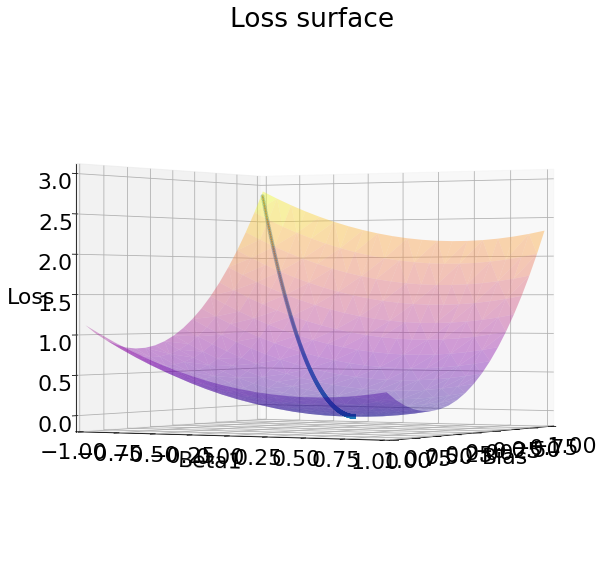

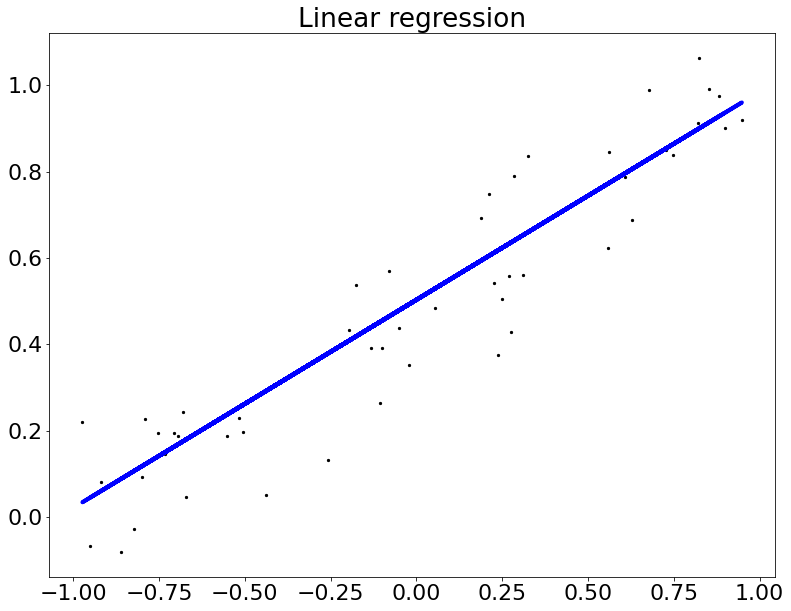

In [10]:
x = torch.tensor(np.random.uniform(low=-1.0, high=1.0, size=50).reshape(-1,1), dtype=torch.float32)
beta_0 = torch.tensor(0.5)
beta_1 = torch.tensor(0.5)
noise = torch.tensor(np.random.normal( 0,.1,50).reshape(-1,1), dtype=torch.float32)
y = beta_0 + beta_1*x + noise


bias =  torch.tensor(np.array([-0.98]))
b1 = torch.tensor(np.array([[-0.99]])) 

epochh = 2500
learningRate = 0.01
pr = True
hehe = GdPlot( model = linearRegression, x_train = x, y_train = y, my_loss = my_loss,
        bias = bias, b1 = b1, epochh = epochh, learningRate = learningRate,
          Vert = 0, Hor = 30, pr = False, optimizer = 'MY')




### NN Loss surface and gradient descent 



In [11]:
import torchvision.transforms as transforms
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()) # Data augmentation is only done on training images
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
seed_everything(12)
print(len(train))
test_abs = int(len(train) * 0.1)
train, _subset = random_split(train, [test_abs, len(train) - test_abs])
print(len(train)) 

60000
6000


## Belwo are the fitted parameters of a neural network I trained earlier

In [12]:
f1w = torch.tensor([[-1.7308e-02,  1.4201e-02,  2.4235e-02,  1.8487e-03,  3.8217e-03,
          2.8966e-02, -2.5056e-02, -8.5744e-03,  9.5557e-03,  1.8876e-03,
          1.5658e-02,  2.3021e-02, -3.0284e-02, -2.8321e-03,  6.3101e-03,
         -1.7083e-02, -2.3876e-03,  1.3414e-02, -1.9675e-02, -1.9004e-02,
         -1.2932e-02, -9.9681e-04,  3.5190e-02, -6.1774e-03, -2.3077e-02,
          8.0527e-03, -1.0870e-02, -7.8316e-03,  1.6746e-02,  1.5188e-02,
         -2.8202e-02,  1.6108e-02, -2.7736e-02, -1.6816e-02,  4.1390e-03,
          1.2719e-01,  1.4983e-01, -2.0263e-01, -6.6774e-01, -9.3798e-02,
          7.4438e-02,  5.9286e-02,  1.1235e+00,  1.1795e+00,  9.5231e-01,
          7.3771e-02, -4.0262e-01, -2.0658e-01,  3.9032e-02, -2.3089e-01,
         -3.7351e-01, -8.3530e-03,  1.1105e-02, -7.2268e-03,  2.5047e-02,
          3.4198e-02,  2.7901e-02, -2.7488e-02,  2.1940e-02, -2.5454e-02,
         -2.0445e-02,  2.1480e-02, -1.6204e-02, -4.4378e-01, -5.9313e-01,
         -1.3142e+00, -8.0957e-01, -9.1081e-01, -1.3599e-01, -3.0382e-01,
          3.3882e-01,  3.0551e-01,  9.3655e-02, -3.3043e-01, -4.7089e-01,
         -4.4384e-01, -6.8627e-01, -8.4639e-01, -7.8758e-01, -1.6004e-01,
         -2.9195e-01, -2.8703e-01,  2.3754e-02,  1.2956e-02, -1.4970e-02,
         -7.7590e-03,  1.5682e-02,  1.7804e-02, -1.2082e-02,  2.0680e+00,
          2.0776e+00, -2.2518e+00, -2.0914e+00, -1.6900e-01, -2.5425e-01,
         -6.7353e-01,  9.3091e-02,  1.0674e+00,  8.5416e-02,  3.4413e-01,
          1.0913e+00,  4.9669e-01,  2.5466e-01, -6.7689e-01, -1.4680e+00,
         -1.6713e+00, -1.1603e+00, -1.7462e+00, -2.3680e+00, -3.3759e-01,
          3.1440e-02, -6.2526e-03,  1.9803e-03, -9.9804e-05, -1.8268e-02,
          2.0863e-02, -8.9919e-01,  1.2639e+00,  9.0668e-01, -9.4873e-01,
          1.0713e+00,  8.8728e-01, -1.0217e-01,  4.3198e-01,  1.3599e+00,
          1.3790e+00,  5.6887e-01,  9.3922e-01,  9.7359e-01,  7.0357e-01,
         -3.8531e-02,  4.5924e-01, -4.5770e-01, -8.3742e-01, -6.3592e-01,
         -2.5437e-01, -5.4159e-01, -5.8514e-01,  2.1439e-03, -3.2462e-02,
         -2.3184e-02, -1.5577e-02,  1.7610e-02, -9.5230e-02, -5.0605e-01,
          9.9002e-01,  1.2833e+00,  1.0294e+00,  1.2043e+00,  7.0886e-01,
          2.3630e-01,  8.1887e-01,  1.2871e+00,  1.1655e+00,  1.0091e+00,
          1.0337e+00,  4.5508e-01,  6.1020e-01,  8.9967e-01,  2.5099e-01,
         -1.5920e-02, -2.8178e-01, -3.7468e-01, -5.2013e-01, -1.1917e-01,
          4.3784e-01,  1.2360e+00,  2.0212e+00,  2.5744e-02, -4.7041e-03,
         -1.2201e-02,  9.8397e-01, -1.6978e-02,  1.6688e+00,  1.0554e+00,
          8.7695e-01,  1.1062e+00,  1.0373e+00,  6.7870e-01,  7.8806e-01,
          6.6020e-01,  4.4268e-01,  6.0047e-01,  7.0644e-01,  6.8003e-01,
          4.2978e-02,  3.7080e-01,  2.7099e-01,  5.0112e-01,  8.8150e-01,
          5.5443e-01,  1.7379e-01,  2.0128e-01,  4.0853e-01,  4.3034e-01,
          1.7807e+00, -2.7830e-02, -1.9783e-02, -3.4207e-01,  6.1479e-01,
         -3.9819e-01, -4.4841e-01, -1.9856e-01,  1.9876e-01,  3.6734e-01,
          1.8042e-01,  1.2800e-01, -2.1876e-01, -3.3203e-01,  4.2403e-01,
          1.1389e-01,  2.0786e-01, -7.4995e-02, -1.0096e-01,  2.3691e-01,
          2.9818e-01,  5.9434e-01,  5.1095e-01,  5.5948e-01,  4.4654e-01,
         -3.6238e-02,  3.2676e-01,  5.5647e-01,  1.6541e+00,  2.1872e-02,
          3.3512e-02, -5.7472e-01, -1.5613e+00, -1.0954e+00, -7.3994e-02,
         -3.1752e-01, -3.2442e-01, -1.8752e-01,  1.2406e-01, -9.9147e-02,
         -5.6268e-01, -5.0197e-01, -6.0115e-01, -7.1146e-01, -4.5035e-01,
         -2.4637e-01, -9.1618e-02,  2.7016e-01,  1.9576e-01,  3.2796e-01,
          3.5375e-01,  7.4123e-01,  5.1266e-01, -4.1581e-01, -2.3168e-02,
          2.6105e-01,  7.5873e-01, -2.3213e-02,  1.9873e-02,  3.5799e-01,
         -1.9425e-01, -1.9740e-01, -4.4755e-01, -5.5298e-01, -5.7224e-01,
         -7.0154e-01, -1.3136e-01, -4.5601e-01, -9.1958e-01, -9.3510e-01,
         -4.6343e-01, -5.1676e-02,  6.7202e-02,  2.8063e-01,  1.8733e-02,
          3.4090e-01,  3.4205e-01,  4.2824e-01,  4.6447e-01,  4.8644e-01,
          7.1977e-01,  1.4769e-01, -2.6951e-01,  1.0884e-01,  7.7205e-01,
         -9.8608e-05,  2.5020e-02,  1.4472e+00,  1.1102e+00,  2.4013e-01,
         -7.7371e-01, -1.8879e-01, -1.5059e-01, -3.7733e-01, -9.4515e-02,
         -4.2564e-01, -2.5095e-01, -5.8889e-01, -3.3819e-01,  2.7322e-01,
          2.0848e-01, -2.0656e-01, -1.1432e-01,  3.7319e-01,  2.3857e-01,
         -5.9381e-02,  2.9477e-01,  6.9996e-01,  1.2150e+00,  6.4135e-01,
          2.8639e-03,  7.5700e-01,  1.8509e+00,  6.1196e-03,  2.6613e-01,
          1.1543e+00,  1.9762e+00, -2.9724e-01, -1.1893e+00, -5.1773e-01,
         -4.8273e-01, -4.0325e-01, -3.3477e-01, -3.5404e-02,  1.0886e-02,
         -1.7334e-01, -2.0180e-01,  2.2452e-01, -1.1955e-02, -5.5508e-01,
         -4.8250e-01, -9.9475e-02,  1.2913e-01, -1.3142e-01,  5.3760e-01,
          3.3725e-01,  7.9618e-01,  7.7550e-01, -1.9859e-01, -1.0774e+00,
          7.7541e-01, -3.0117e-02,  3.6656e-01,  1.2986e-01,  1.4256e+00,
         -9.4507e-01, -8.3962e-01, -7.5022e-01, -2.2015e-01, -2.2068e-01,
         -2.9895e-02,  3.7082e-01,  1.1369e-01, -6.7062e-02, -9.9935e-02,
          4.5117e-01,  2.0403e-02, -7.2534e-01, -8.4626e-01, -7.9672e-01,
         -8.1216e-01, -7.7396e-01, -7.8202e-03,  4.5049e-01,  9.3833e-01,
          1.0373e+00,  2.0743e+00, -8.8322e-01,  4.1124e-03,  8.7776e-01,
          3.4350e-01,  8.3582e-01, -5.1952e-01, -9.4354e-01, -2.3124e-01,
         -6.2407e-01, -6.2570e-01, -6.9262e-01, -1.6004e-01,  4.3064e-01,
          3.8938e-01,  1.5262e-01,  6.3227e-01,  2.4011e-01, -4.4693e-01,
         -9.1466e-01, -7.7855e-01, -1.1120e+00, -1.3393e+00, -8.8975e-01,
         -4.6430e-02,  8.2679e-01,  9.8270e-01,  1.1274e+00,  1.4803e+00,
          2.2583e-01, -2.1165e-03, -1.6229e-02, -3.2108e-02, -2.9591e-02,
         -2.2322e+00, -1.0780e+00, -1.3805e-01, -2.7003e-01,  1.2084e-01,
          3.2336e-01,  2.1540e-01,  4.4057e-01,  1.8709e-01,  1.0795e-01,
          4.2151e-01, -3.1355e-02, -3.2030e-01, -6.8175e-01, -6.0421e-01,
         -7.9117e-01, -7.3414e-01, -3.4523e-01,  2.5433e-01,  5.8613e-01,
          5.2025e-01,  1.0846e+00,  3.5975e-01, -4.0716e-01,  1.5791e-02,
         -1.7307e-02, -5.8542e-03, -8.6595e-02, -2.1358e+00, -5.8649e-01,
         -3.4188e-02,  1.1881e-01,  3.2617e-01,  4.1625e-01,  6.4755e-02,
          1.3959e-01,  3.1855e-02,  8.9660e-03,  3.1558e-01,  2.4596e-01,
         -3.1539e-01, -7.8964e-01, -6.2577e-01, -3.7713e-01,  2.7541e-02,
          2.3671e-03,  4.1950e-01,  3.9094e-01,  6.9394e-01,  9.5269e-01,
         -5.8958e-01, -4.8364e-01, -1.0494e-02,  1.0369e-03, -3.1821e-01,
          5.3729e-01,  2.6903e-02, -4.8421e-01,  3.1501e-01,  2.9590e-01,
          7.8150e-02,  6.6555e-01,  2.1147e-01, -1.5965e-01, -3.7622e-01,
         -2.9920e-01, -4.3424e-02, -3.1011e-01, -7.6763e-01, -8.6524e-01,
         -4.2063e-01, -1.1137e-01, -2.9957e-01,  2.5657e-01,  2.1667e-01,
          5.4988e-01,  1.2069e+00, -1.0548e-01, -1.0070e+00, -1.4492e+00,
          2.3201e-02,  2.4369e-02, -2.2146e-01,  3.1178e-02,  9.9801e-01,
          3.5422e-01, -3.8481e-02,  3.2944e-01,  4.6540e-01,  1.9126e-01,
          1.3981e-01,  2.8859e-01, -1.0464e+00, -7.5545e-01, -5.1920e-01,
         -6.9066e-01, -5.0682e-01, -4.5349e-01, -7.6743e-02,  1.4552e-01,
          4.3819e-01,  6.9720e-02,  5.4439e-01,  5.0039e-01,  7.8334e-01,
         -2.1701e-01, -7.1773e-01, -1.0966e+00,  6.6364e-01,  1.2411e-02,
          1.4524e-02, -5.2811e-01,  9.9287e-01,  4.1055e-01,  7.8138e-01,
          8.8611e-01,  7.6046e-01,  6.1057e-01, -6.0432e-01,  4.0528e-01,
         -3.2384e-01, -6.2842e-01, -5.1969e-01, -7.8803e-01, -3.4434e-01,
          7.4589e-03,  3.3265e-01,  7.9155e-01,  8.6732e-01,  4.0786e-01,
          1.2696e+00,  1.3087e+00,  4.8169e-01,  3.4430e-01, -7.2104e-01,
         -8.0038e-01,  6.8006e-01, -1.4814e-02, -4.8305e-01, -5.9044e-01,
          2.6515e-01,  6.4783e-01,  1.4194e+00,  1.2443e+00,  8.5348e-01,
          6.5168e-01, -3.7257e-02,  7.0059e-01,  7.6290e-01,  1.4914e-01,
          9.4180e-02, -1.5186e-01, -5.8766e-02,  6.6833e-01,  7.3024e-01,
          5.5321e-01,  1.0390e+00,  1.2501e+00,  1.0248e+00,  7.0758e-01,
          6.9376e-02, -3.9469e-01, -8.1199e-01, -3.2416e-01,  6.9235e-01,
          3.3082e-02, -9.7143e-02,  1.4897e+00,  8.7536e-01,  8.9210e-01,
          1.1079e+00,  1.0224e+00,  8.6997e-01,  4.2917e-01,  2.4712e-01,
          8.0936e-02,  4.3027e-01,  5.6490e-01, -1.1347e-02,  2.7458e-01,
          4.2395e-01,  1.5220e-01, -1.4636e-01,  5.7473e-01,  1.0383e+00,
          7.3468e-01,  8.0142e-01,  5.8895e-01, -6.7157e-02, -5.6424e-01,
         -3.3894e-01, -2.7619e-01,  7.0352e-01,  2.3432e-02, -5.4258e-02,
          6.6944e-01,  1.0340e+00,  7.6764e-01,  1.1333e+00,  9.2313e-01,
          1.1238e+00,  7.6321e-01,  5.7428e-01,  6.1068e-01,  3.7008e-01,
          3.5415e-01, -1.2927e-01,  4.7571e-02,  4.0810e-01, -2.4253e-01,
          8.9999e-02,  7.3255e-01,  2.5954e-01,  4.7391e-01,  3.5534e-01,
          4.4835e-01, -5.1079e-01, -8.2483e-01, -3.1573e-01, -3.4995e-01,
          6.2038e-03, -2.6919e-02, -6.1278e-02,  1.6330e+00,  1.1038e+00,
          1.5794e-01,  9.0701e-01,  1.4165e+00,  1.3437e+00,  1.0334e+00,
          5.1922e-01,  6.0427e-01,  7.4012e-01,  5.1946e-01,  7.6085e-01,
          8.0852e-01,  6.4024e-01,  5.8937e-01,  1.9326e-01, -2.2386e-01,
          4.2074e-01,  4.9126e-01,  1.1051e-01,  5.7976e-01, -1.0024e-01,
         -6.5336e-01, -3.2845e-01, -7.1961e-01,  1.3371e-02, -2.2572e-04,
         -4.3802e-03,  1.9060e+00,  2.0897e+00,  8.7429e-01,  1.8001e-01,
          3.8298e-01,  1.0559e+00,  7.4270e-02,  3.8373e-02,  9.1049e-02,
          7.6305e-01,  1.0134e+00,  8.5836e-01,  9.7888e-01,  1.1867e+00,
          7.5021e-01, -1.7916e-01, -1.6338e-01,  2.6673e-01, -3.3733e-01,
         -5.6336e-01, -1.2876e+00, -1.1008e+00, -5.1290e-01, -1.1093e+00,
         -8.3679e-01, -1.0937e-02,  3.0376e-02,  8.7920e-03,  1.3969e-01,
         -4.2220e-01, -1.2186e+00, -1.5125e+00,  1.1294e+00,  1.3618e+00,
         -1.0156e-01, -2.6740e-01,  3.7880e-01,  4.1342e-01,  7.0362e-01,
          5.7978e-01,  4.6570e-01,  7.7907e-01,  6.9412e-01,  2.5434e-01,
         -1.0124e+00, -8.4349e-01, -7.8265e-01, -1.7193e-01, -1.8176e+00,
         -4.6900e-01, -1.9299e-01, -1.0269e+00,  6.6629e-04, -3.4551e-02,
          1.3914e-02,  1.4283e-02,  3.5642e-02, -1.0347e+00, -1.0198e+00,
         -2.1828e+00, -7.1289e-02, -6.0286e-01, -2.6895e-01, -6.6860e-01,
         -5.9706e-01, -7.5764e-01,  2.2685e-01, -7.4729e-01, -9.6415e-01,
         -8.6583e-01, -7.9275e-01,  6.0868e-02, -5.3321e-02, -6.5991e-01,
         -3.4409e-01, -5.2487e-01,  1.3345e-01,  2.3125e-01,  2.3157e-01,
         -1.2564e-02,  2.2080e-02, -2.5138e-02, -2.2207e-02,  2.6108e-02,
         -1.0334e-02, -3.4937e-02, -6.2624e-01, -6.6796e-01, -1.9036e+00,
         -1.6320e+00, -1.3866e+00, -8.5215e-01, -7.6407e-01, -9.1848e-01,
         -8.7793e-01, -9.6665e-01, -1.0662e+00, -1.1837e+00, -1.1389e+00,
         -7.0556e-01, -7.5770e-01, -5.2549e-01, -1.8551e-01, -1.0112e-01,
          2.8928e-01,  3.3320e-03, -2.0751e-02, -1.1287e-02,  2.2087e-02,
          2.3378e-03, -1.5143e-02,  1.2757e-02, -4.6451e-03,  3.3172e-02,
          1.5259e-02,  3.5509e-03, -3.0410e-01, -2.5790e-01, -2.8541e-01,
         -8.4330e-01, -8.2175e-01, -6.6780e-01, -5.9377e-01, -6.7757e-01,
         -5.6015e-01, -1.2265e+00, -6.6934e-01, -7.9749e-01, -8.9806e-01,
         -3.9676e-01, -4.1496e-01, -4.0740e-01, -1.9113e-02, -2.8668e-02,
         -2.4918e-02,  8.9655e-03,  2.9260e-02, -5.9913e-03],
        [-4.3064e-03, -3.5537e-02, -1.3806e-02, -2.2507e-02,  1.9954e-02,
          2.0218e-02, -2.0411e-02,  2.8468e-03,  9.9839e-03,  1.5792e-02,
         -1.7256e-02,  3.3198e-02,  1.6167e-02,  3.0342e-02,  3.4135e-02,
          5.8183e-03,  2.3593e-02,  1.4721e-02,  3.2229e-03,  2.1894e-02,
          8.1156e-03, -1.7618e-02,  1.0944e-02, -1.1114e-02,  1.6877e-02,
          3.8971e-03, -2.8314e-02, -1.9142e-02, -2.7380e-02, -4.9550e-03,
          1.4484e-02, -2.8892e-02, -3.3541e-02, -1.5786e-02, -1.2376e-02,
          3.7924e-01,  4.1106e-01,  2.9824e-01,  6.2898e-02,  3.9548e-01,
          4.8716e-01,  4.2142e-01,  6.9195e-01,  7.5149e-01,  4.6003e-01,
          4.7030e-01,  7.5496e-01,  5.9428e-01,  3.8495e-01,  3.5086e-01,
          1.5576e-01,  1.4799e-02,  9.6791e-03,  3.5432e-02, -1.8490e-02,
          2.2245e-02, -3.2513e-02, -7.6188e-03,  2.4697e-03,  8.3742e-03,
         -1.9986e-02,  8.6783e-03,  3.4191e-01,  2.2120e-01,  2.3824e-01,
          3.8426e-01,  7.4114e-01,  8.0489e-01,  7.4746e-01,  5.1175e-01,
          5.1930e-01,  4.3409e-01,  4.6683e-01,  4.2607e-01,  4.6053e-01,
          4.7982e-01,  7.4610e-01,  8.5437e-01,  7.3395e-01,  4.4735e-01,
          1.9316e-01,  2.2564e-01, -3.0933e-03, -4.5633e-03, -3.0754e-02,
          3.4551e-02,  2.4555e-02, -2.1109e-03,  3.4557e-02, -8.6936e-01,
         -1.4471e+00,  1.3516e+00,  1.5761e+00,  1.5880e+00,  1.2669e+00,
          1.4095e+00,  8.4720e-01,  5.5442e-01,  8.6699e-01,  6.7266e-01,
          5.1964e-01,  8.1597e-01,  9.1162e-01,  7.9882e-01,  6.7180e-01,
          5.9257e-01,  5.8638e-01,  2.2247e+00,  2.1322e+00,  5.3428e-01,
          1.5153e-02, -1.2708e-02, -5.5156e-03, -2.1380e-02, -1.3348e-02,
          3.5382e-02,  1.3245e+00,  1.2658e+00,  1.4604e+00, -6.8337e-01,
          5.8372e-01,  7.1331e-01,  5.4765e-01,  5.1097e-01,  5.5408e-01,
         -2.1465e-01, -1.8496e-01,  1.3266e-01,  2.7672e-01,  1.8913e-01,
          2.2877e-01, -1.7746e-02, -1.0012e-01,  1.7119e-01, -3.3025e-01,
         -3.8939e-01,  8.5696e-02, -3.9876e-01,  1.9361e-01, -5.3765e-03,
          2.5338e-02,  3.5346e-02, -1.6467e-02,  1.5919e-01,  1.7277e+00,
          1.1738e+00,  5.9390e-01,  5.0120e-01,  6.8352e-01,  2.9815e-01,
          7.0021e-02, -1.6018e-02,  5.5818e-01,  4.2151e-01,  9.2625e-02,
          2.0319e-01,  1.7788e-01, -4.4492e-01,  1.5443e-01,  5.4962e-01,
          2.2406e-01, -2.0902e-01, -6.8223e-02, -8.4960e-01, -7.3119e-01,
         -2.7228e-01, -3.3380e-02, -2.4346e-01,  2.5681e-02,  4.4650e-03,
         -2.9274e-02,  1.6489e+00,  1.0934e+00,  7.9275e-01,  1.1937e-01,
          5.9066e-01,  9.7994e-01,  2.7281e-01, -1.5088e-01,  1.7882e-02,
          7.3679e-01,  4.6616e-01, -3.2642e-02,  1.1531e-01, -2.8903e-01,
         -6.6578e-01, -1.9664e-01, -2.5544e-01, -3.2168e-01, -7.3051e-02,
         -6.2213e-01, -1.1120e+00, -9.1124e-01, -6.9359e-01, -2.8084e-01,
         -3.4168e-01,  1.1533e-02, -1.3474e-02, -5.3053e-02,  1.6080e+00,
          1.7089e-01, -2.2453e-01, -1.5586e-01,  5.0234e-01, -3.5055e-01,
         -4.7188e-01, -4.8240e-01, -1.5759e-01, -3.6080e-01, -1.4741e-01,
         -2.4317e-02, -2.5818e-01, -4.6723e-01,  6.2311e-01, -5.6264e-02,
          1.0628e-01,  4.5321e-01,  1.9004e-01, -8.5826e-01, -1.2267e+00,
         -1.2965e+00, -1.2575e+00, -3.2856e-01, -2.8444e-01,  6.3572e-04,
          8.0764e-03, -3.3245e-02,  8.5486e-01, -2.8660e-02, -3.1033e-01,
          1.1623e-02,  3.2925e-01, -4.4035e-01,  2.8128e-01, -6.6382e-02,
         -6.7532e-01, -5.1693e-01,  3.2235e-03,  1.2392e-01, -1.7732e-01,
         -3.7466e-01, -2.6150e-01, -1.8552e-01, -6.9424e-02,  1.7202e-01,
         -4.4272e-01, -4.5548e-01, -9.1880e-01, -1.1154e+00, -1.0301e+00,
         -6.0076e-01, -5.1651e-02,  1.1229e-02, -3.7473e-02,  3.3652e-01,
          9.0809e-01,  2.9074e-01, -4.9090e-01, -3.4592e-01, -2.9684e-01,
         -2.4697e-01, -1.1259e-01, -3.9547e-01, -8.3851e-01, -9.3055e-01,
         -4.2589e-01,  2.6310e-01,  5.1136e-01, -3.3941e-01, -6.5184e-01,
         -1.7845e-01, -1.7571e-01, -1.3495e-01, -6.2379e-01, -2.3902e-02,
         -2.8880e-01, -7.0322e-01, -9.4659e-01,  4.0326e-02,  1.4810e+00,
         -1.3442e-03, -3.0992e-02,  1.2274e+00,  9.7587e-01, -2.4423e-01,
         -9.6892e-01, -8.4758e-01, -4.4393e-01, -3.3732e-01, -6.9603e-01,
         -7.0400e-01, -1.1257e+00, -1.0752e+00, -7.0492e-01,  3.9403e-01,
          4.5264e-01, -1.4742e-01, -1.3536e-02, -2.6069e-02, -2.6371e-01,
         -3.4612e-01, -7.7687e-01, -4.5540e-01, -2.3192e-01,  2.8450e-01,
         -3.3675e-01,  1.0834e-01,  1.1841e+00, -1.7561e-02,  9.1795e-02,
          1.0683e-01,  8.1884e-01, -4.8614e-01, -9.6014e-01, -9.3601e-01,
         -7.0899e-01, -7.3424e-01, -9.0146e-01, -7.3705e-01, -9.6057e-01,
         -6.1584e-01, -3.4171e-01,  2.6991e-01,  2.2110e-02,  5.9487e-02,
         -2.4476e-01, -4.0144e-01, -5.6585e-01, -1.8644e-01,  2.4451e-01,
         -2.9253e-01, -1.7965e-01, -6.7354e-02, -2.1069e+00, -5.9816e-01,
         -7.4977e-02,  1.4114e-02, -2.5749e-02, -1.0792e+00,  6.7410e-01,
         -7.1524e-01, -9.0254e-01, -6.2619e-01, -7.8927e-01, -3.9276e-01,
         -3.9781e-01, -5.8609e-01, -5.3954e-01,  2.4320e-01, -1.0921e-01,
          2.1314e-01,  4.0696e-02,  1.5490e-03, -4.4477e-01, -5.8001e-01,
         -5.4898e-01, -2.3737e-01, -6.1815e-02, -8.2289e-02,  7.7729e-01,
          1.6214e+00,  4.7974e-01,  1.4380e-01, -4.1008e-03,  6.4608e-01,
         -8.0624e-02, -1.8601e+00,  7.2496e-01, -4.2863e-01, -8.3296e-01,
         -2.9210e-01, -7.3224e-01, -5.0395e-01,  2.3738e-01, -1.2435e-01,
         -1.3127e-01,  6.6915e-01, -6.0262e-03,  4.3504e-01, -8.0114e-02,
         -2.1119e-01,  1.6445e-01,  3.1594e-02, -3.5320e-01, -8.7842e-02,
          3.1893e-01,  2.5534e-01,  8.8833e-01,  8.4046e-01,  1.2800e+00,
          1.3326e+00, -3.4884e-02, -2.1322e-02, -5.9248e-02, -3.1625e-02,
          1.2720e-01, -3.6097e-01,  2.4624e-01,  6.5753e-01, -5.6768e-02,
         -4.1165e-01,  7.1807e-01,  1.0708e-01, -1.0472e-01, -1.2262e-01,
          3.8920e-01,  3.3671e-01, -7.2134e-02, -4.7514e-01, -3.1397e-01,
         -3.9065e-01, -4.6014e-01,  1.5432e-01,  1.5263e-01,  1.9654e-01,
         -1.2082e-01, -8.0779e-01, -1.1213e+00, -6.7235e-01,  1.1925e-02,
          5.6006e-03,  3.0281e-02, -7.0591e-02, -6.0947e-01,  1.9451e-01,
          1.5040e-01,  5.8639e-01,  3.9796e-01,  4.3714e-02,  6.8354e-02,
          4.0472e-01,  3.8711e-01,  2.8381e-01,  2.3986e-01,  2.7889e-01,
          6.9112e-01, -5.3149e-01, -2.3155e-01,  2.0154e-01,  9.7846e-02,
          4.8102e-01,  2.6817e-01,  7.4061e-02, -3.7277e-01,  2.6810e-01,
          1.0887e+00,  1.4336e+00, -1.9041e-02, -9.8240e-03, -4.4823e-01,
          1.7328e-01,  2.9781e-01,  2.0626e-01, -1.7193e-01, -1.3677e-01,
          4.5413e-01, -1.3034e-01, -3.6505e-01, -6.0516e-02, -3.9561e-03,
         -3.2324e-01,  7.3755e-01,  6.7099e-01, -1.0017e-01, -5.6625e-01,
          2.0304e-03,  4.9147e-01,  2.8268e-01,  5.6349e-01, -1.1643e-01,
          1.7712e-01,  1.9787e-01,  1.0691e+00,  1.8236e+00,  1.9125e+00,
          2.6517e-03,  1.1168e-02, -3.4236e-01,  3.7400e-01, -2.5821e-01,
         -3.6932e-01, -1.5910e-01, -1.0772e-01, -2.9776e-01, -7.4496e-01,
         -2.1149e-01,  3.5092e-01, -4.8909e-01,  2.1243e-01,  5.6147e-01,
          3.1693e-01,  3.2467e-01, -1.2834e-01, -9.1403e-02,  1.6336e-01,
          1.0958e-01,  6.9733e-01,  1.0594e-01,  6.9516e-02,  2.2111e-01,
         -1.0787e-02, -1.1865e-01,  9.1084e-01,  4.9639e-01, -1.2386e-02,
          2.2806e-02,  2.2119e-01,  1.0445e+00, -5.0429e-01,  9.7421e-01,
         -4.9427e-01,  7.7540e-01, -2.9346e-01, -4.5753e-01,  2.1856e-01,
          2.0228e-01,  7.0582e-01,  5.6029e-01,  2.8068e-02,  1.4537e-01,
          2.7166e-02, -1.0701e-01,  6.3076e-01,  4.3928e-01,  3.2564e-01,
         -5.9308e-02, -7.8298e-02,  2.1694e-01, -4.9969e-01, -1.0922e-01,
         -2.1971e-02,  5.5964e-01,  9.6268e-03, -4.0858e-01, -3.4748e-03,
          1.7850e+00, -3.0345e-01,  3.2190e-01, -2.6059e-01,  2.3104e-01,
         -9.4534e-02,  8.6738e-02,  2.1541e-01,  5.1615e-01,  6.7196e-01,
          5.4433e-01, -4.4895e-02, -1.3844e-02,  1.4438e-01,  3.7492e-01,
          6.6827e-01,  4.7693e-01,  2.0730e-01,  3.2717e-01,  3.9098e-01,
          6.0947e-01, -3.3672e-01,  3.0372e-02, -7.4597e-02,  5.5263e-01,
         -1.9708e-02, -7.5363e-02,  1.1646e+00,  1.7679e+00,  3.1217e-01,
         -1.2770e-01,  7.3703e-02, -7.2404e-01,  2.4549e-01,  4.8310e-01,
          2.9945e-01,  1.6764e-01,  2.1808e-01,  3.5680e-01,  3.7744e-01,
          2.4739e-01,  4.5675e-01,  3.5185e-01,  6.7785e-01,  5.7933e-01,
          4.5383e-01,  5.5088e-01,  7.8182e-01,  1.0782e+00,  8.0872e-01,
          7.8216e-01,  4.5857e-01, -5.8257e-02, -2.5063e-02, -6.8821e-02,
         -6.5827e-01,  5.9186e-01,  4.6587e-01,  6.2503e-01,  1.9011e-01,
          1.0734e+00,  4.2964e-01,  1.8644e-01,  5.5154e-01, -4.6615e-02,
         -4.4541e-03,  2.0097e-01,  6.1088e-01,  4.5910e-01,  3.2617e-01,
         -7.8150e-02, -1.2086e-01,  9.6709e-01, -3.3607e-01, -3.5103e-01,
          4.2610e-01,  8.8752e-01,  5.9767e-01,  4.0770e-01,  7.2669e-01,
          2.8817e-03,  9.0925e-03, -6.5912e-02,  7.6409e-01,  1.2891e+00,
         -1.0422e-01,  3.3741e-01,  7.7558e-01,  8.3590e-01,  5.1427e-01,
          7.2825e-01,  3.8818e-01, -1.7824e-01, -4.2296e-01, -4.4787e-01,
         -4.1850e-01,  1.1055e-01,  5.9179e-01,  4.5458e-01,  1.1498e-01,
          2.0701e-01, -4.0585e-01, -4.5415e-02,  1.1305e+00,  5.0269e-01,
         -5.2637e-01,  4.9543e-01,  9.6093e-01, -8.7571e-03, -9.1594e-03,
         -1.9659e-02,  1.4483e+00,  1.5697e+00,  5.8422e-01,  7.3390e-01,
          8.4716e-01,  8.6135e-01,  1.3370e-01,  2.9577e-01,  1.7240e-01,
         -4.2673e-01, -2.2285e-01, -5.6282e-01, -5.9109e-01,  1.8046e-01,
          1.7316e-01, -3.5613e-01, -6.5440e-01, -2.5625e-01, -1.8898e-01,
         -8.4442e-02, -4.6842e-02, -1.2555e+00, -4.2082e-01,  2.6057e-02,
          1.0812e+00,  1.4525e-02,  5.5287e-03, -6.6041e-04, -9.0043e-01,
         -4.3306e-01,  8.6455e-01,  1.2481e+00,  1.3929e+00,  1.1419e+00,
         -9.7777e-02,  5.0881e-01,  5.7515e-01,  1.0069e-01,  3.4214e-01,
          2.5778e-01,  3.0587e-01,  1.7995e-01, -3.0709e-01, -7.7450e-01,
         -8.2491e-01, -6.9734e-01, -1.1755e+00, -7.9157e-01, -7.6164e-01,
         -7.7855e-01,  1.1435e+00,  5.2422e-01, -8.8121e-03,  2.7863e-02,
         -7.6682e-03, -3.4432e-02,  3.1984e-02, -9.0180e-01, -9.0507e-01,
         -7.3731e-01, -9.7078e-01, -1.3352e+00, -1.2991e+00, -1.1799e+00,
         -1.3583e+00, -8.0130e-01,  1.3817e-01, -1.4592e-01, -3.5756e-01,
         -7.6533e-01, -8.0444e-01, -3.7927e-01, -3.5494e-01, -7.0150e-01,
         -5.6113e-01, -5.9266e-01, -4.0124e-01, -1.6203e-01, -1.4916e-01,
          2.7632e-02, -1.5954e-02, -3.1463e-02, -2.3301e-02,  6.4636e-03,
          3.3128e-03, -3.4966e-02, -6.2272e-01, -6.4018e-01, -5.8198e-01,
         -5.3101e-01, -2.8393e-01, -2.4912e-01, -2.2622e-01, -5.6868e-01,
         -2.7603e-01, -3.7956e-01, -3.8463e-01, -1.6289e-01, -1.3003e-01,
         -1.4772e-01, -3.0271e-01, -2.9399e-01, -6.9108e-02, -9.9593e-02,
         -3.7456e-02, -2.8896e-02, -3.4124e-02,  3.4126e-02,  2.6690e-02,
         -1.9786e-02, -2.7426e-02,  2.6184e-02,  2.5676e-02,  3.1603e-02,
          6.1740e-03, -2.8545e-02, -8.7418e-02, -1.1395e-01, -6.9833e-02,
         -1.8611e-01, -1.4198e-01, -5.1687e-02, -7.1457e-02, -1.1837e-01,
         -1.4265e-01, -1.1441e-01, -1.2216e-01, -1.9513e-01, -4.0879e-01,
         -1.0113e-01, -4.8783e-02, -8.1534e-02,  2.2778e-02, -1.6985e-02,
          2.6400e-02, -4.6802e-03,  6.2714e-03, -2.3447e-03],
        [ 9.4356e-03,  1.6163e-02, -5.3778e-03,  1.6442e-02, -1.2754e-02,
          1.3623e-02, -3.4307e-02, -1.5762e-02,  8.6287e-03, -1.5292e-02,
          1.0080e-02,  1.5524e-02,  1.3748e-03,  2.0131e-02,  2.5703e-02,
         -2.3698e-02,  9.6539e-03, -1.5639e-02, -3.2316e-02, -1.2793e-02,
          1.5297e-02,  3.1663e-02, -2.2778e-02, -3.1360e-02,  1.9682e-02,
          1.5147e-02,  3.0232e-02,  3.3428e-02,  2.4455e-02, -5.5496e-03,
          2.1494e-02,  1.0453e-02,  2.2686e-03,  1.3312e-02, -1.1095e-02,
          3.9719e-02,  7.0727e-02,  2.9099e-01,  5.1715e-01, -2.9095e-02,
         -8.3634e-02,  1.1537e-01, -9.3299e-01, -1.0426e+00, -7.4121e-01,
          2.8016e-02, -4.2201e-01, -1.1581e-01,  1.6429e-01,  3.4475e-01,
          4.4202e-01,  3.2183e-03,  2.7601e-03, -9.8588e-03,  2.4977e-02,
         -3.4403e-02, -1.3756e-02, -7.8454e-03,  2.5429e-02,  3.3105e-02,
         -1.5341e-02, -1.7468e-02,  2.4185e-01,  6.3377e-01,  6.6583e-01,
          7.7341e-01,  4.0823e-02,  1.0477e-02,  9.7005e-02,  7.1633e-01,
          3.2212e-01,  5.7906e-01,  3.9996e-01,  2.8359e-01,  3.3677e-01,
          2.9357e-01, -3.1818e-02, -9.3044e-02,  9.4625e-02,  2.8376e-01,
          1.8649e-01,  1.5409e-01, -2.6191e-02, -2.3484e-02, -1.8584e-02,
         -1.5994e-02,  3.0389e-02,  1.7729e-02, -8.2593e-04, -1.3000e+00,
         -6.9749e-01,  8.9787e-01,  2.9396e-01, -4.7607e-01, -3.6149e-01,
         -6.8997e-01, -1.9395e-01, -1.5598e-01, -2.7971e-01, -3.6497e-01,
         -4.0511e-01, -4.8935e-01, -8.1872e-01, -1.2540e-01,  9.4583e-01,
          1.1945e+00,  6.4573e-01, -1.6652e+00, -1.3833e+00,  1.8086e-01,
          1.0462e-02,  6.3705e-03,  7.0972e-03, -2.7749e-02, -2.2766e-02,
          8.6206e-03,  9.7714e-01, -4.5028e-01,  1.1458e-01,  1.7852e+00,
          6.4721e-03,  3.8446e-01,  7.1994e-01,  7.5794e-02, -7.6525e-01,
          1.5634e-01,  6.1333e-01, -9.3319e-02, -1.6134e-01, -1.1678e-01,
          3.0322e-01, -6.3841e-01, -7.2562e-01, -1.1782e+00, -2.3699e-01,
          6.6152e-01,  5.5122e-01,  9.1123e-01,  7.1704e-01,  2.5016e-02,
         -2.5181e-02,  1.3837e-02,  8.0777e-03,  4.8593e-01,  1.2629e+00,
          6.8851e-01,  7.1264e-01,  7.9812e-01,  1.1051e+00,  1.6008e+00,
          1.8065e+00,  1.2330e+00,  4.4029e-01,  8.6021e-01,  5.6099e-01,
          3.5703e-01,  7.3007e-01,  7.7358e-01,  4.0759e-01,  5.1865e-01,
         -2.1331e-01, -1.8204e-01,  5.1825e-01,  1.4013e+00,  9.5924e-01,
          4.3344e-01, -9.3324e-01, -1.3200e+00,  3.0687e-02, -1.8234e-02,
         -2.0573e-03, -1.3112e+00,  2.5936e-02, -6.6947e-01,  4.4946e-01,
          3.2610e-01,  4.3227e-01, -5.3932e-03,  7.0412e-01,  3.0752e-01,
         -4.2484e-02,  1.5546e-01, -2.4487e-04, -1.7026e-01, -3.6757e-01,
          7.2529e-02, -1.7561e-01,  5.3309e-01,  7.9429e-01, -1.7907e-01,
          6.4436e-01,  1.2185e+00,  1.2334e+00,  1.1240e+00,  7.7270e-01,
          3.4118e-01, -2.6961e-02, -9.0510e-04, -4.2554e-01, -1.0888e+00,
         -1.6715e+00, -3.5105e-01,  2.5799e-01, -2.2835e-01,  2.9256e-01,
          2.1525e-01,  3.7264e-01, -7.2947e-02, -7.5979e-01, -1.0117e+00,
         -8.4241e-01, -6.2340e-01, -6.8419e-01, -9.8288e-01, -2.5859e-01,
          1.0780e-01,  8.6024e-02,  2.0297e-01,  9.3123e-01,  1.0016e+00,
          1.4152e+00,  1.4135e+00,  1.1365e+00,  3.3129e-01,  3.5379e-02,
         -3.4387e-02, -3.9821e-01,  4.5634e-01,  1.5287e-01, -6.1933e-01,
         -7.1807e-01, -1.7372e-01,  8.7217e-02, -2.1034e-01, -4.2761e-01,
         -1.3257e-01, -8.5992e-01, -9.2066e-01, -9.7994e-01, -6.1354e-01,
         -4.5723e-01, -3.8715e-01, -7.5551e-02,  2.8310e-01,  3.7626e-01,
          4.6230e-01,  2.6426e-01,  2.5966e-01,  1.4190e+00,  1.5833e+00,
          1.3709e+00,  1.2063e-01, -2.4712e-02, -5.5879e-02, -5.0966e-01,
          1.4984e-01, -1.8181e-01, -1.1955e-01, -8.2676e-01, -2.3840e-01,
          1.5153e-01, -1.4926e-01, -2.9229e-01,  7.9596e-02, -6.3356e-01,
         -1.2633e+00, -1.1562e+00, -1.2003e+00, -8.0804e-01, -4.7373e-01,
         -2.1250e-01, -2.2072e-01,  2.7719e-01,  8.1640e-01,  2.7442e-01,
         -1.7480e-01,  1.5594e+00,  1.9810e+00, -1.8456e-01, -2.5139e+00,
         -2.9168e-03, -3.7018e-02, -1.3471e+00, -4.3675e-01,  3.3068e-01,
         -3.1622e-01, -1.4897e+00, -1.6194e-01,  5.9951e-02,  3.1738e-01,
         -1.6648e-01, -2.2664e-01,  1.8189e-01, -6.3331e-01, -1.0751e+00,
         -1.0036e+00, -8.4670e-01, -1.8109e-01, -5.5563e-01, -5.6899e-01,
         -1.5675e-01,  5.6456e-01, -1.2048e-01, -2.7342e-01,  1.8774e+00,
          2.1307e+00, -1.8848e-01, -9.7639e-01, -2.7841e-02, -1.0694e+00,
         -7.5751e-01, -1.1457e+00, -1.0455e+00,  1.6539e-01, -3.8943e-01,
          7.2917e-02, -1.0273e-01,  4.9407e-01, -1.0975e-01,  9.7153e-01,
          6.0098e-01,  7.5449e-01,  1.4076e-01, -4.0338e-01, -1.3009e-01,
          5.1541e-02, -7.0767e-01, -9.0082e-01, -1.0710e+00, -1.2153e+00,
         -9.6835e-01, -1.1740e-01,  1.5575e+00,  2.8546e+00,  2.5031e+00,
          1.8863e+00, -2.9416e-03, -4.0205e-02,  8.0467e-01, -1.4162e+00,
         -1.3279e+00, -1.3687e-01, -9.7210e-02, -6.5501e-01, -1.5523e-01,
          4.6725e-02,  2.3619e-01,  9.6860e-01,  6.7506e-01,  1.0612e+00,
          2.6357e-01, -5.0481e-01,  3.6065e-01, -4.0372e-01, -6.6320e-01,
         -6.9418e-01, -6.4812e-01, -8.8096e-01, -9.9191e-01, -9.5183e-01,
         -4.8984e-01, -3.7104e-01,  1.7595e+00, -1.1301e-04, -6.5997e-01,
          8.0314e-03,  1.1291e+00, -1.5705e+00, -1.0681e+00, -5.4382e-02,
          3.8582e-01,  2.0254e-01,  4.6552e-01,  3.3949e-01,  6.0826e-01,
          1.1211e+00,  7.5239e-01,  5.4948e-01, -2.2112e-03,  4.3741e-01,
          2.5060e-01, -1.0278e-01, -6.5847e-01, -4.2144e-02, -4.4210e-01,
         -2.2158e-01, -1.0490e+00, -1.0071e+00, -1.0665e-01, -1.8708e-01,
         -7.0041e-02, -8.2775e-04,  2.5358e-02, -1.5867e-02, -4.7959e-02,
         -1.0474e+00,  1.5832e-01,  3.8357e-01,  3.3296e-01,  1.1017e-01,
          1.0281e-01, -1.2399e-01,  7.2369e-01,  1.0055e+00,  7.1791e-01,
          6.3583e-01,  1.1464e-01, -1.8207e-01, -1.6781e-02,  2.4965e-01,
         -1.3739e-01, -4.0472e-01, -1.7956e-01,  2.9728e-01,  7.6493e-02,
          5.3298e-01,  1.9236e+00,  1.5621e-01,  2.5245e-01, -3.4091e-02,
          3.7787e-03, -8.8137e-03,  4.2608e-01, -2.2579e-01, -3.6325e-02,
          1.0171e+00, -1.8624e-02,  2.6723e-01,  3.9918e-01,  6.6249e-01,
          1.0518e-01,  1.6918e-01,  1.3467e-01,  7.4852e-01,  2.9817e-01,
          2.6885e-02,  7.6600e-01,  2.3659e-01, -3.8805e-01, -4.1024e-02,
         -5.5754e-02,  5.1513e-02,  4.9219e-01,  7.9153e-01,  1.2848e+00,
          3.5422e-01, -6.5606e-01, -1.2469e-02, -6.7832e-04, -4.2410e-01,
         -7.4755e-02,  1.0493e+00,  2.0077e-01,  4.3444e-02,  9.9017e-02,
          2.1156e-01, -1.8700e-01,  2.6040e-01, -3.7497e-01,  4.8257e-01,
          9.1328e-01,  5.2093e-01,  1.8072e-01,  1.9000e-01,  8.3408e-01,
          2.7025e-02, -6.7901e-02,  4.4212e-01, -8.4997e-02,  7.1669e-01,
          1.9323e-01, -6.2236e-01,  6.1473e-01,  2.4539e-02, -5.0105e-01,
          2.4773e-02, -1.8401e-02, -3.5355e-01,  5.3823e-01,  8.8372e-01,
          4.7899e-01,  4.7740e-02, -2.8433e-01, -2.8612e-01,  1.4512e-01,
         -2.5064e-01, -3.0507e-01,  9.8714e-01,  1.0056e+00,  5.5444e-01,
          2.0713e-01, -3.5294e-01,  1.0772e-01, -3.7712e-01,  1.6710e-01,
          3.0323e-01, -1.5694e-01,  9.3125e-02,  1.9935e-01,  5.1817e-01,
          9.9772e-01,  6.8905e-01, -3.4008e-01, -5.4182e-01, -1.0433e-02,
          3.0887e-02,  9.9444e-01,  3.3675e-01,  1.1039e+00, -9.9096e-02,
          3.9191e-01, -1.9670e-01,  3.4628e-02,  5.0153e-01, -9.1234e-02,
          5.6971e-01,  6.9353e-01,  6.6069e-01,  5.5587e-01,  9.1092e-02,
         -1.8337e-01,  1.4193e-01, -2.0531e-01, -1.5231e-01,  1.9281e-01,
         -2.8593e-01, -3.8422e-01,  5.5968e-01,  4.6312e-01,  4.9809e-01,
          6.0335e-01, -5.5831e-01, -3.5232e-02,  2.1749e-01,  1.3609e+00,
         -2.0676e-01,  6.1529e-01,  6.7739e-01,  6.3036e-01,  5.1642e-01,
          1.0800e-01, -1.0692e-01, -4.4820e-01, -6.8499e-01, -2.4421e-01,
          2.2447e-01,  2.6279e-01,  5.3889e-01, -2.1418e-01,  7.6376e-02,
          4.1032e-01,  2.9142e-01,  2.4178e-01,  2.6508e-01,  5.6828e-02,
          4.9013e-01,  4.9534e-01,  3.5405e-01,  3.3663e-01, -5.8056e-01,
          4.2298e-03,  5.3241e-01, -9.7428e-02, -6.2616e-01, -1.1602e-01,
          1.0109e+00,  1.3262e+00,  1.1825e+00,  5.3614e-01,  3.3758e-02,
          1.4026e-01,  2.3275e-01, -5.6995e-01, -3.2487e-01, -3.6516e-01,
          4.1287e-01,  3.8529e-01,  6.1467e-01,  9.8902e-01,  7.5637e-01,
          8.7215e-01,  4.1379e-01,  4.0583e-02,  9.7596e-02,  4.4058e-01,
          1.1818e-01,  2.9066e-01, -1.7371e-02, -1.3142e-02,  6.7051e-01,
          1.5906e+00,  8.4963e-01,  3.6096e-01,  5.7684e-01,  1.4706e+00,
          3.3078e-01,  8.8372e-01,  6.9883e-01,  1.1223e-01,  3.1185e-02,
         -7.1124e-02,  1.5061e-01,  1.4524e-01,  8.1466e-01,  5.8094e-01,
          1.0497e+00,  1.1681e+00,  8.9228e-01,  1.1901e+00,  1.1767e+00,
         -1.6456e-01,  4.7496e-01,  6.3349e-01,  1.0465e-01,  2.9510e-01,
         -1.2949e-02,  1.0586e-02,  6.5408e-01, -5.6653e-02,  8.4919e-01,
          1.6268e+00,  5.7237e-01,  6.6191e-01,  2.1974e-01, -1.0498e-01,
          5.8462e-01,  1.2760e-01,  2.0193e-01,  5.6102e-01,  2.3062e-01,
         -4.8454e-02,  4.4276e-01, -2.9044e-02,  7.6769e-02,  5.5531e-01,
          4.7213e-01,  6.6696e-01,  1.3784e+00, -1.2242e+00, -3.7618e-01,
          1.2846e+00,  2.4475e-01,  4.2631e-01, -8.7949e-03,  2.0358e-03,
          2.1019e-02, -1.6542e+00, -1.4325e+00,  1.1473e+00,  6.8621e-01,
          1.0001e+00,  9.4739e-01,  5.9605e-01,  3.5258e-01,  7.1742e-01,
          7.3717e-01,  3.1356e-01,  5.2562e-01,  4.2034e-01,  5.1939e-01,
         -5.6093e-02, -4.6854e-01,  1.6772e-01, -1.1109e-01,  9.6168e-01,
          1.6562e+00, -5.3562e-01,  7.4836e-01,  2.0201e+00,  1.6686e+00,
          8.2083e-01, -1.5720e-02, -1.1427e-02, -1.1050e-02,  1.0741e+00,
          1.4763e+00,  1.4573e+00,  5.6482e-02,  3.6675e-02,  3.7484e-01,
          8.9264e-01, -1.2082e+00, -1.5496e-01,  3.5059e-01,  6.7836e-01,
          6.3526e-01,  4.6009e-01,  1.0971e+00, -2.6098e-02, -2.1203e-01,
          2.2197e-01,  3.3642e-01,  1.9488e-01, -9.6691e-01, -3.7332e-01,
         -1.9904e-01,  7.3970e-01,  1.4744e+00, -2.5339e-02, -3.0000e-02,
         -3.0274e-02, -1.8743e-02,  2.2021e-02,  5.8652e-01,  5.3902e-01,
         -8.8947e-01, -7.1674e-01, -4.5448e-02, -9.9990e-02, -4.3035e-01,
          4.5553e-01, -9.9768e-01, -1.0502e+00, -9.0002e-01, -7.5343e-01,
         -1.1409e+00, -7.5261e-01, -4.6230e-01, -5.4843e-01, -5.0996e-01,
         -1.7742e+00, -1.6808e+00, -1.3058e+00, -1.3014e+00, -7.3327e-01,
          7.7245e-03,  2.8319e-02, -1.0896e-03, -1.0359e-02,  1.4463e-02,
         -2.1441e-02,  2.7807e-02,  2.3333e-02, -1.5826e+00, -1.5768e+00,
         -1.7576e+00, -1.1043e+00, -9.8404e-01, -7.7583e-01, -5.8865e-01,
         -7.2916e-01, -6.9532e-01, -6.1024e-01, -5.2185e-02, -3.9583e-01,
         -7.7299e-01, -9.9208e-01, -1.1832e+00, -1.1799e+00, -1.2581e+00,
         -5.9761e-01,  1.3563e-02, -1.7207e-03, -6.3981e-03,  2.0283e-02,
          2.4532e-02, -1.9884e-02, -5.3439e-04, -6.6605e-04,  3.1766e-02,
          2.0758e-02,  2.5139e-02, -2.0933e-02, -2.7448e-02,  1.0279e-02,
          1.9781e-02,  2.2579e-01, -1.1102e-01, -9.7372e-02, -2.5583e-01,
         -1.1009e+00, -1.4269e-01, -3.2914e-01, -2.1294e-01,  3.2889e-01,
          1.2641e-01,  6.4858e-02, -8.1806e-02, -2.1327e-02, -3.5628e-02,
          2.5401e-02,  2.7512e-02, -6.9395e-03,  5.1818e-03],
        [-1.5891e-02, -1.3399e-03, -6.1344e-03,  2.6013e-02, -2.4009e-02,
         -3.0351e-02, -8.2404e-03, -3.3762e-02, -1.8802e-02,  1.7177e-02,
          1.5741e-02,  3.1485e-02,  3.3569e-02,  2.7593e-02,  7.7704e-03,
          3.3027e-02, -6.9944e-03,  1.5886e-02,  2.3142e-03, -1.9820e-02,
         -3.0987e-03,  3.5425e-02,  1.9304e-02,  1.7156e-02,  1.1429e-02,
         -9.9783e-03,  5.0480e-03,  2.9180e-02, -2.8825e-02,  9.3779e-03,
         -5.4652e-03, -2.1164e-02, -1.4696e-02, -1.7156e-02,  1.3920e-02,
          3.8040e-01,  4.0638e-01,  6.6586e-01,  9.9502e-01,  5.7527e-01,
          4.8097e-01,  4.2531e-01, -6.6900e-01, -1.0431e+00, -4.0630e-01,
          4.8361e-01,  8.0232e-01,  5.2509e-01,  3.7083e-01,  5.2736e-01,
          5.5957e-01,  1.2234e-02,  3.0933e-02, -8.4840e-03, -2.3319e-02,
         -2.1759e-02, -1.0288e-02, -3.5624e-02, -7.8854e-03, -2.1303e-02,
          2.9815e-02, -1.4660e-02,  3.7593e-01,  5.8323e-01,  6.1925e-01,
          1.4217e+00,  1.3217e+00,  1.2590e+00,  7.3411e-01,  8.3670e-01,
          4.3465e-01,  4.3800e-01,  5.0935e-01,  6.2542e-01,  8.5220e-01,
          7.7997e-01,  9.8124e-01,  1.0575e+00,  9.0643e-01,  4.3533e-01,
          3.3409e-01,  3.2177e-01, -1.8832e-02,  2.8075e-02,  1.3421e-02,
         -1.1929e-02,  3.0193e-02,  2.5681e-02,  3.7521e-03, -2.7507e+00,
         -1.9272e+00,  2.3053e+00,  2.3500e+00,  1.1254e+00,  5.8347e-01,
          1.1107e+00,  5.3111e-01, -4.3628e-01,  4.9397e-01,  3.4865e-01,
         -1.5789e-01,  5.0183e-01,  5.6472e-01,  9.7024e-01,  1.5979e+00,
          1.6449e+00,  6.2432e-01,  2.5797e+00,  3.0682e+00,  4.0105e-01,
         -2.2630e-02, -1.1314e-02,  2.6142e-02,  2.8928e-02,  3.1687e-03,
          1.8401e-02,  1.3280e+00, -7.0626e-01, -1.0555e+00,  9.1328e-01,
         -4.7869e-02, -1.6010e-01,  4.3071e-01,  4.7692e-02, -4.3385e-01,
          1.4958e-01,  5.9922e-01,  2.0036e-01,  4.4897e-01,  4.6900e-01,
          5.0464e-01, -4.1621e-01,  7.7948e-01,  5.2061e-01,  1.9497e-02,
          5.2465e-01,  8.7418e-01,  7.1530e-02,  5.8723e-02,  2.7150e-02,
          7.1351e-04,  2.8410e-02, -1.2603e-02, -1.8519e-01,  1.7150e+00,
         -5.8514e-01, -2.2621e-01,  2.7819e-01, -2.4195e-01,  3.9322e-02,
          4.8667e-01, -4.3161e-02,  1.0183e+00,  7.5767e-01,  7.2523e-02,
          2.8056e-01,  4.2101e-01,  1.6979e-01, -1.9826e-01,  1.9102e-02,
         -6.8225e-01, -5.5587e-01, -9.4488e-01, -2.1645e-01, -1.0637e-01,
         -3.3040e-01, -8.9806e-02, -5.7380e-02, -6.2733e-03,  1.4158e-02,
          2.2762e-02, -2.7065e-01, -2.2146e-01, -7.0187e-01,  5.8966e-01,
          2.3688e-01,  1.0725e+00,  2.7065e-01,  3.3979e-01,  2.8328e-01,
          2.6054e-01, -5.8056e-02, -3.7367e-01, -3.3136e-01, -4.1957e-01,
         -2.0496e-02, -4.5049e-01, -2.6941e-01, -1.0178e+00, -7.0242e-01,
         -8.5370e-01, -3.7703e-01, -3.7756e-01, -2.3351e-01, -1.3557e+00,
         -1.6271e+00,  1.5399e-02, -3.1086e-02, -8.6681e-02,  3.9097e-01,
          3.5138e-01, -8.6656e-01,  7.9242e-01,  9.9844e-01,  1.2637e-01,
         -5.8861e-01, -7.4395e-01,  3.7797e-01, -5.8340e-01, -1.0552e+00,
         -2.6448e-01, -6.4331e-01, -3.8600e-01, -5.3237e-01, -5.1721e-01,
         -9.3351e-01, -1.3814e+00,  6.7222e-02,  4.6505e-02, -1.7026e+00,
         -6.2368e-01,  2.7383e-01, -1.2696e+00, -1.6330e+00,  3.0997e-02,
          2.0773e-02, -4.7345e-02,  7.3318e-01,  1.4127e+00, -8.4366e-01,
         -2.3599e-01, -6.3334e-01, -2.4432e-01,  1.8579e-01,  1.6543e-01,
         -9.8802e-02, -3.8451e-01, -1.1797e-01,  2.9667e-01, -6.4438e-01,
         -8.1315e-01, -6.8212e-01, -6.6289e-01, -8.2703e-01, -8.6587e-01,
         -2.4390e-01, -9.9370e-01, -8.4133e-01, -8.0182e-01, -8.5522e-01,
         -2.8632e-01, -5.9178e-03, -2.5340e-02, -8.3825e-02, -9.5845e-02,
         -2.7568e-01, -2.9093e-01, -1.1180e-01, -7.2009e-01, -8.1875e-01,
          6.8615e-01, -1.5354e-01,  5.7619e-02,  5.5836e-01,  2.5745e-02,
          1.2580e-01, -2.9672e-01, -1.1591e+00, -1.0549e+00, -7.7115e-01,
         -7.1534e-01, -9.0985e-01, -5.1266e-01,  1.4748e-01, -2.6923e-02,
         -5.1694e-02, -9.0651e-01, -1.2174e+00, -1.6449e+00, -1.6451e+00,
         -5.6391e-04, -8.7140e-02, -1.8988e-01, -1.2623e+00, -1.1552e+00,
         -3.9582e-01, -7.1363e-01, -7.5778e-01, -1.5959e-02, -6.0596e-01,
         -4.2332e-01, -1.0420e-01, -1.3785e-01, -5.1475e-01, -4.6555e-01,
         -8.1414e-01, -6.0682e-01, -5.4852e-01, -8.0345e-01, -3.5898e-01,
         -7.7501e-02,  1.8659e-02, -3.7687e-01,  3.1489e-01, -2.9057e-01,
         -1.4604e+00, -1.7900e+00, -1.6114e+00, -7.3411e-03,  1.1668e+00,
         -7.2606e-02, -1.8321e+00, -4.3245e-01, -5.3451e-01, -9.3628e-01,
         -5.0717e-01, -6.5537e-01, -8.0305e-01, -1.1181e+00, -8.8640e-01,
         -1.1851e+00, -5.4565e-01, -2.0799e-01, -5.1380e-01,  3.1607e-01,
         -1.4969e-01, -2.3591e-01, -2.8235e-01, -3.4721e-01, -2.4043e-01,
          3.0152e-02, -5.4437e-02, -6.3633e-01, -7.3248e-01, -1.0808e+00,
         -6.5269e-02, -1.5306e-02, -6.9897e-02,  9.0910e-02, -1.8065e+00,
         -1.3026e+00, -8.1021e-01, -8.1722e-01, -9.2715e-01, -1.1422e+00,
         -1.0696e+00, -9.2818e-01, -8.8708e-01, -9.1241e-01, -8.8788e-02,
         -2.0789e-01, -5.7995e-01, -3.9632e-01, -2.2710e-01,  1.2520e-01,
         -3.1426e-01,  3.4354e-02,  2.2977e-01,  2.9771e-01,  5.0114e-01,
          1.0745e+00,  8.1435e-01,  7.0447e-01,  3.2875e-03, -5.3169e-02,
         -3.9441e-02,  3.0686e-01, -9.8393e-01, -1.6736e+00, -1.2121e+00,
         -8.0393e-01, -8.8411e-01, -1.0143e+00, -7.3542e-01, -5.7592e-01,
         -4.2714e-01, -3.5666e-01, -3.5138e-01, -1.1825e-01,  9.5161e-02,
         -2.2709e-01,  1.3530e-01,  3.3674e-01, -4.5980e-01, -3.8949e-01,
          5.8276e-01,  1.5425e-01,  6.6424e-01,  1.0933e+00,  5.1238e-01,
          7.7067e-01,  6.2761e-04, -1.7024e-02, -1.3361e-02, -7.0852e-02,
         -1.3272e+00, -1.9954e+00, -1.2087e+00, -1.2598e-01, -3.2900e-01,
         -5.1287e-01,  3.1048e-01,  6.1798e-02,  6.0809e-01,  2.1511e-02,
         -2.4863e-01,  7.2100e-02,  1.0185e-01,  5.6943e-02,  1.9816e-01,
         -3.0048e-01, -5.9187e-01, -4.0448e-01,  5.8924e-01,  4.8568e-01,
          4.4398e-01, -7.9199e-01,  4.8978e-01,  6.2255e-01, -3.3171e-02,
         -3.0729e-02,  6.0696e-03, -5.3368e-01, -9.7865e-01, -1.2833e+00,
         -2.8162e-01,  3.4698e-01,  7.2468e-03,  1.5955e-01,  6.8517e-01,
          8.1532e-01,  7.4574e-01,  3.1353e-01, -1.3086e-01, -5.3971e-02,
          2.5976e-01,  3.5325e-01,  4.6742e-02,  4.0713e-02, -2.3315e-01,
          2.7780e-01, -5.6642e-01,  5.8969e-01, -6.9933e-01,  3.7132e-01,
          6.1586e-01,  1.5539e+00,  1.2933e-02, -1.3747e-02, -3.9831e-01,
         -7.0709e-01, -3.1365e-01, -2.4715e-01, -1.2147e+00,  4.2630e-02,
          2.4172e-01, -2.6611e-02,  8.9848e-01,  9.9450e-01,  1.1686e+00,
          6.6907e-01,  2.6626e-01,  2.5290e-01,  6.2031e-02,  4.4464e-01,
          1.4089e-01, -1.2206e-01, -5.5198e-02,  1.5007e-02, -1.2771e-01,
         -4.9537e-02, -1.4048e-01,  1.5073e+00,  1.6371e+00,  2.2080e+00,
          6.6865e-03,  2.0844e-02, -3.4059e-01,  5.0344e-01, -9.6370e-01,
          9.8411e-01,  4.3408e-01,  1.0177e-01, -2.2628e-02,  5.6943e-01,
          3.1088e-01,  3.9585e-01,  8.3800e-01,  6.5591e-01,  4.2969e-01,
          3.7899e-01,  2.1938e-02,  1.9078e-01, -7.2713e-02,  3.0245e-02,
          2.1606e-01,  1.0204e+00,  4.2276e-01,  7.6629e-01,  1.2355e-01,
          1.0862e+00,  7.5968e-01,  1.7389e+00, -2.8594e-01, -3.5211e-02,
         -1.1377e-02,  8.8593e-01, -1.2706e+00,  1.4203e+00,  8.9923e-01,
          3.1634e-01,  8.1219e-01,  9.3371e-01,  5.8341e-01,  4.8105e-01,
          6.8154e-01,  7.9315e-01,  7.3455e-01,  7.3358e-01,  4.1403e-01,
          6.7659e-01,  3.1823e-01,  5.6501e-01,  7.6473e-02,  1.5861e-01,
         -3.9408e-01,  1.1045e-03,  5.4007e-02,  4.7830e-01,  6.2786e-01,
          8.4858e-01, -3.3558e-01,  2.8619e-02, -1.8806e-01,  1.0215e+00,
         -6.4005e-01, -8.3925e-02, -6.1299e-02,  4.4052e-01,  9.0713e-01,
          4.8512e-01,  5.7422e-01,  6.8402e-01,  7.4392e-01,  5.9049e-01,
          6.0511e-01,  3.6910e-01,  3.1822e-01,  7.0939e-01,  3.2424e-01,
          4.8342e-01,  9.4945e-02,  1.3032e-01,  7.3357e-01,  6.9821e-01,
          6.8592e-01,  6.5490e-01,  5.4176e-01,  3.0233e-01, -3.1508e-01,
          5.8236e-04, -1.6379e-01,  3.6876e-01, -5.2031e-01, -1.1535e-01,
         -3.2441e-01,  4.1980e-01,  3.6126e-01,  5.8662e-01,  5.5596e-01,
          1.0297e+00,  5.2908e-01,  4.2397e-01,  1.1562e-01,  2.7919e-02,
          6.1774e-01,  8.5283e-01,  6.4769e-01,  1.1931e+00,  6.2192e-01,
          6.8077e-01,  7.8486e-01,  8.3351e-01,  1.1096e+00,  8.0078e-01,
          1.3799e-01,  3.3789e-01, -5.0535e-02,  2.2512e-02, -1.5786e-01,
          2.1034e-04,  1.2794e+00,  1.1357e+00,  4.3545e-01,  1.1539e+00,
          3.9246e-02, -4.3735e-02, -3.9013e-01,  2.7376e-01,  4.5861e-01,
          2.7645e-01,  9.2054e-01,  9.9237e-01,  2.0825e-01, -5.0662e-01,
          8.9737e-03,  4.0917e-01,  1.1280e+00,  1.9315e-01,  7.0919e-01,
          9.9737e-01,  1.3600e+00,  7.3216e-01, -1.0996e-01,  3.7121e-01,
         -2.4428e-02, -1.7035e-02, -1.4846e-01,  3.9265e-02,  1.2860e+00,
          1.3310e+00, -4.1638e-01,  7.9019e-01,  5.3729e-01,  1.6752e-01,
          5.5788e-01,  3.0211e-03, -2.8866e-01, -3.8696e-01, -6.4272e-01,
         -4.1616e-01, -4.0998e-01, -7.2360e-01, -5.0333e-01,  4.1771e-01,
          8.6514e-01,  5.3950e-01,  4.9741e-01,  1.1955e-01,  7.7402e-02,
          7.7040e-01,  4.3179e-01,  9.1997e-01,  9.7087e-04,  1.7095e-02,
          1.7882e-02, -1.9688e-01, -1.6039e+00, -1.2382e+00,  1.0372e-03,
          3.5698e-01, -2.6801e-01,  5.9902e-01,  1.0052e-01, -1.1575e-01,
         -5.2457e-01, -6.1941e-01, -3.9811e-01, -3.0654e-01, -4.3406e-01,
         -3.2988e-01, -6.7630e-01, -1.4714e-01,  4.7390e-02,  4.9327e-01,
          3.5068e-01, -2.1841e-01, -6.4172e-01,  1.7097e+00,  2.3155e+00,
          1.7370e+00,  5.5173e-03,  3.7940e-03, -1.3397e-03,  3.5206e-02,
         -5.4794e-01,  1.9294e+00,  1.5180e+00, -3.0296e-01, -1.1319e+00,
          1.5963e-01, -2.4542e-02, -2.7001e-01, -4.2309e-01, -3.7186e-01,
         -2.3990e-01, -2.4041e-01, -4.2217e-01, -5.1024e-01, -1.0482e+00,
         -6.8444e-01, -9.9027e-01, -2.3881e-01, -1.7152e-01, -1.2508e+00,
         -1.5157e+00,  1.1867e+00,  2.2850e+00,  3.5373e-02, -1.6791e-02,
          3.0404e-02,  2.1603e-02,  1.7425e-02, -5.6989e-01, -5.8963e-01,
         -5.1672e-01, -1.9101e-01, -3.3962e-02, -2.6401e-02, -1.5630e-01,
         -2.7470e-01, -2.4052e-01, -1.9405e-01, -2.9163e-01, -4.2304e-01,
         -5.2893e-01, -6.8376e-01, -4.7000e-01, -4.4725e-01, -6.0103e-01,
         -7.7650e-01, -7.5098e-01, -1.4196e+00, -1.8686e+00, -9.1622e-01,
          1.1078e-02, -8.5976e-03, -2.5640e-02, -1.9120e-02, -9.9397e-03,
         -4.9271e-03, -8.6475e-05, -3.3150e-02, -7.8433e-02, -8.8588e-02,
         -4.4730e-02, -1.2080e-01, -1.5656e-01, -7.1955e-02, -1.1631e-01,
         -1.6506e-01, -1.5898e-01, -8.7438e-02, -1.0637e-01,  1.0032e-01,
          4.5604e-01,  2.4125e-01, -2.3999e-01, -1.7826e-01, -1.5484e-01,
         -5.8297e-02, -5.6426e-03, -2.7143e-02, -2.8356e-03,  3.3947e-02,
         -3.2467e-02, -1.9035e-02, -2.1117e-03, -2.6056e-02, -2.9215e-03,
         -1.1720e-02,  8.8207e-03, -8.1801e-02, -6.9634e-02, -5.0831e-02,
         -4.3342e-02, -3.2927e-02, -4.4834e-02, -4.0143e-02, -4.4668e-02,
         -6.9172e-02, -4.0023e-02, -3.6724e-02, -2.5612e-02, -8.4756e-02,
         -5.7417e-02, -5.2677e-02, -3.4631e-02, -2.8482e-02,  1.8885e-02,
         -3.2643e-02, -3.1291e-02, -2.4209e-02, -3.3691e-02]],
       requires_grad=False)

f1b = torch.tensor([ 0.8005,  0.8337,  0.3131, -0.2532], requires_grad=False)

f2w=torch.tensor([[ 1.3869,  0.8484, -0.2181, -1.6727],
        [-0.1286, -0.7525,  0.5895, -0.6315],
        [ 0.2061,  0.9691,  0.4982,  1.2950],
        [ 0.7232, -1.7553,  1.4772, -0.4905]], requires_grad=True)

f2b = torch.tensor([ 1.0124,  1.8921, -1.1958, -0.4275], requires_grad=False)

f3w = torch.tensor([[ 0.3251, -1.8371, -1.3847,  0.5358],
        [ 0.9132, -1.8494, -0.3046, -2.0143],
        [-0.7107, -1.7601,  0.6970,  0.2273],
        [ 1.2659, -1.8751, -1.0884, -0.1376],
        [-1.7773,  0.0149, -0.3362,  0.6547],
        [-0.6930, -0.3480, -0.5106,  0.9016],
        [-0.6577, -1.4964,  0.5074, -0.1326],
        [-0.2935,  1.8103, -0.3860, -2.0961],
        [-1.1630, -0.6219, -0.7656,  1.4042],
        [-0.5725,  1.8729, -1.2415, -0.9322]], requires_grad=True)

f3b = torch.tensor([-0.9845, -0.7846, -0.9749, -0.8735, -0.6949, -1.5540, -0.8289,  1.3768,
        -0.8450,  1.4925], requires_grad=False)
hide_toggle()

In [13]:
class ANN(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_dim, title ):
        super(ANN, self).__init__()
    
        # Input Layer (784) -> 784
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
        with torch.no_grad():

            self.fc1.weight = torch.nn.Parameter(f1w, requires_grad=False)
            self.fc1.bias = torch.nn.Parameter(f1b, requires_grad=False)
            self.fc2.weight = torch.nn.Parameter(f2w,requires_grad=True) 
            self.fc2.bias = torch.nn.Parameter(f2b, requires_grad=False)
            self.fc3.weight = torch.nn.Parameter(f3w,requires_grad=True)
            self.fc3.bias = torch.nn.Parameter(f3b, requires_grad=False)
            

            
            
                
            #starting points
            self.fc2.weight[0][0] = -1.5
            self.fc3.weight[0][0] = 3.
            #print(self.fc1.bias)



    
    # Feed Forward Function
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)       
        return nn.Sigmoid()(x)
    


# Full batch GD

In [14]:
"""model=ANN( input_dim = 784 ,hidden_dim = 4, output_dim = 10 , title = "GD")

torch.set_printoptions(edgeitems=3)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr = 2.9)
 
epochs = 200

xx = []
yy = []
zz = []
train_loader = torch.utils.data.DataLoader(train, batch_size = len(train), shuffle = True)
for e in range(epochs): # training our model, put input according to every batch.  
    #Entering Training mode
    model.train()
         
    for inputs, labels in train_loader:
            
        inputs = Variable(inputs.view(-1, 28*28))  
        labels = labels
        
  
        #Outputs of model
        outputs = model(inputs)
            
        #Loss of outputs
        loss = criterion(outputs, labels)
        #print("loss",loss.item())
        zz.append(loss.item())
        optimizer.zero_grad() 
            
        #gradient step
        loss.backward()
        
        for name, param in model.named_parameters():     

            #print(name,param)
            if name == "fc2.weight": 

                xx.append(param.data[0][0].item())
                #print(param.data[0][0].item())
                param.grad.data[0][1].zero_()
                param.grad.data[0][2].zero_()
                param.grad.data[0][3].zero_()
                
                param.grad.data[1][:].zero_()
                param.grad.data[2][:].zero_()
                param.grad.data[3][:].zero_()
           

            if name == "fc3.weight":
                yy.append(param.data[0][0].item())
                param.grad.data[0][1].zero_()
                param.grad.data[0][2].zero_()
                param.grad.data[0][3].zero_()
                
                param.grad.data[1][:].zero_()
                param.grad.data[2][:].zero_()
                param.grad.data[3][:].zero_()
                param.grad.data[4][:].zero_()
                param.grad.data[5][:].zero_()
                param.grad.data[6][:].zero_()
                param.grad.data[7][:].zero_()
                param.grad.data[8][:].zero_()
                param.grad.data[9][:].zero_()

        optimizer.step()

"""        
        
        
#MINI BATCH GD
model=ANN( input_dim = 784 ,hidden_dim = 4, output_dim = 10, title = "BGD" )


    
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr = 0.9, momentum=0.0)
 
epochs = 5

xxmb = []
yymb = []
zzmb = []

train_loader = torch.utils.data.DataLoader(train, batch_size = 84, shuffle = True)
for e in range(epochs): # training our model, put input according to every batch.  
    #Entering Training mode
    model.train()
         
    for inputs, labels in train_loader:
            
        inputs = Variable(inputs.view(-1, 28*28))  
        labels = labels
        
  
        #Outputs of model
        outputs = model(inputs)
            
        #Loss of outputs
        loss = criterion(outputs, labels)
        #print("loss",loss.item())
        zzmb.append(loss.item())
        optimizer.zero_grad() 
            
        #gradient step
        loss.backward()
        
        for name, param in model.named_parameters():     

            #print(name,param)
            if name == "fc2.weight": 

                xxmb.append(param.data[0][0].item())
                #print(param.data[0][0].item())
                param.grad.data[0][1].zero_()
                param.grad.data[0][2].zero_()
                param.grad.data[0][3].zero_()
                
                param.grad.data[1][:].zero_()
                param.grad.data[2][:].zero_()
                param.grad.data[3][:].zero_()
           

            if name == "fc3.weight":
                yymb.append(param.data[0][0].item())
                param.grad.data[0][1].zero_()
                param.grad.data[0][2].zero_()
                param.grad.data[0][3].zero_()
                
                param.grad.data[1][:].zero_()
                param.grad.data[2][:].zero_()
                param.grad.data[3][:].zero_()
                param.grad.data[4][:].zero_()
                param.grad.data[5][:].zero_()
                param.grad.data[6][:].zero_()
                param.grad.data[7][:].zero_()
                param.grad.data[8][:].zero_()
                param.grad.data[9][:].zero_()
        
                

        optimizer.step()

        
#MINI BATCH GD
model=ANN( input_dim = 784 ,hidden_dim = 4, output_dim = 10, title = "BGD" )


    
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr = 0.9, momentum=0.9)
 
epochs = 2

xxmbb = []
yymbb = []
zzmbb = []

train_loader = torch.utils.data.DataLoader(train, batch_size = 230, shuffle = True)
for e in range(epochs): # training our model, put input according to every batch.  
    #Entering Training mode
    model.train()
         
    for inputs, labels in train_loader:
            
        inputs = Variable(inputs.view(-1, 28*28))  
        labels = labels
        
  
        #Outputs of model
        outputs = model(inputs)
            
        #Loss of outputs
        loss = criterion(outputs, labels)
        #print("loss",loss.item())
        zzmbb.append(loss.item())
        optimizer.zero_grad() 
            
        #gradient step
        loss.backward()
        
        for name, param in model.named_parameters():     

            #print(name,param)
            if name == "fc2.weight": 

                xxmbb.append(param.data[0][0].item())
                #print(param.data[0][0].item())
                param.grad.data[0][1].zero_()
                param.grad.data[0][2].zero_()
                param.grad.data[0][3].zero_()
                
                param.grad.data[1][:].zero_()
                param.grad.data[2][:].zero_()
                param.grad.data[3][:].zero_()
           

            if name == "fc3.weight":
                yymbb.append(param.data[0][0].item())
                param.grad.data[0][1].zero_()
                param.grad.data[0][2].zero_()
                param.grad.data[0][3].zero_()
                
                param.grad.data[1][:].zero_()
                param.grad.data[2][:].zero_()
                param.grad.data[3][:].zero_()
                param.grad.data[4][:].zero_()
                param.grad.data[5][:].zero_()
                param.grad.data[6][:].zero_()
                param.grad.data[7][:].zero_()
                param.grad.data[8][:].zero_()
                param.grad.data[9][:].zero_()
        
                

        optimizer.step()
        
        


In [15]:

class ANN(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_dim ,fc2,fc3):
        super(ANN, self).__init__()
    
        # Input Layer (784) -> 784
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
        with torch.no_grad():

            self.fc1.weight = torch.nn.Parameter(f1w, requires_grad=False)
            self.fc1.bias = torch.nn.Parameter(f1b, requires_grad=False)
            self.fc2.weight = torch.nn.Parameter(f2w,requires_grad=True) 
            self.fc2.bias = torch.nn.Parameter(f2b, requires_grad=False)
            self.fc3.weight = torch.nn.Parameter(f3w,requires_grad=True)
            self.fc3.bias = torch.nn.Parameter(f3b, requires_grad=False)
            
            #starting points
            self.fc2.weight[0][0] = fc2
            self.fc3.weight[0][0] = fc3
            #print(self.fc1.bias)

    
    # Feed Forward Function
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)       
        return nn.Sigmoid()(x)

fc2x = np.linspace(-4,4,20)  
fc3x = np.linspace(-4,4,20)

xxx = []
yyy = []
zzz = []
        
for fc2 in fc2x:
    for fc3 in fc3x:
        seed_everything(12)
        train_loader = torch.utils.data.DataLoader(train, batch_size = len(train), shuffle = True)
        model=ANN( input_dim = 784 ,hidden_dim = 4, output_dim = 10,fc2=fc2,fc3=fc3)
        xxx.append(fc2)
        yyy.append(fc3)

        torch.set_printoptions(edgeitems=3)

        criterion = nn.CrossEntropyLoss()

        optimizer = optim.SGD(model.parameters(),lr = 0.1)



         # training our model, put input according to every batch.  
            #Entering Training mode
        model.train()

        """for inputs, labels in train_loader:

            inputs = Variable(inputs.view(-1, 28*28))  
            labels = labels
            for name, param in model.named_parameters():
                if name == "fc2.weight":
                    param.data[0][0] = fc2
                    xxx.append(fc2)
                                    #print(name,param)

                if name == "fc3.weight":
                    param.data[0][0] = fc3
                    yyy.append(fc3)
                                    #print(name,param)"""


        outputs = model(inputs)
        loss = criterion(outputs, labels)
                                #print(loss.item())
        zzz.append(loss.item())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


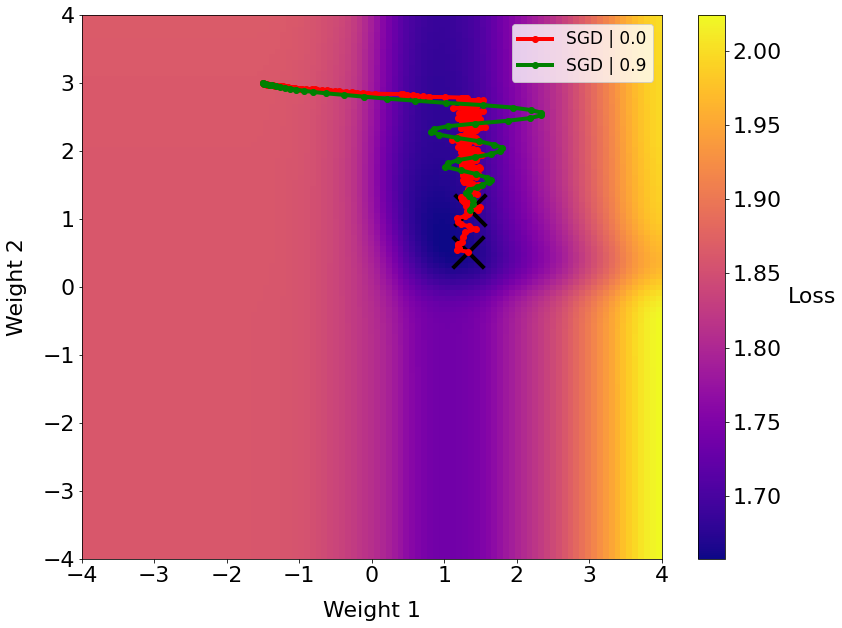

In [16]:








fig2 = plt.figure(figsize=(13,10))
ax = fig2.add_subplot() 




#Grid mesh i.e plotting functions surface in 2D
xi = np.linspace(min(xxx), max(xxx), 100)
yi = np.linspace(min(yyy), max(yyy), 100)
X, Y = np.meshgrid(xi, yi)
Z = griddata((np.round(xxx,3), np.round(yyy,3)), np.round(zzz,3), (X, Y), method='nearest')
Z = gaussian_filter(Z, sigma=3)

    
c = ax.pcolormesh(X, Y, Z, cmap='plasma')

#ax.plot(np.round(xx,3), np.round(yy,3), c="grey", antialiased=True, label='GD', linewidth=4, marker = 'o', markersize = 6)
ax.plot(xxmb, yymb,   c="red", antialiased=True, label='SGD | 0.0', linewidth=4, marker = 'o', markersize =6)
ax.plot(xxmbb, yymbb, c="green", antialiased=True, label='SGD | 0.9', linewidth=4, marker = 'o', markersize = 6)
#ax.plot(xxmbbb, yymbbb, c="blue", antialiased=True, label='SGD | 2 0.0', linewidth=4, marker = 'o', markersize = 7)




#ax.scatter(xx[-1], yy[-1], s = 1000, antialiased=True, c = 'black',marker = 'x' ,linewidth=4)
ax.scatter(xxmb[-1], yymb[-1],  s = 1000, antialiased=True, c = 'black',marker = 'x' ,linewidth=4 )
ax.scatter(xxmbb[-1], yymbb[-1],  s = 1000, antialiased=True, c = 'black',marker = 'x' ,linewidth=4 )

ax.legend(prop={'size': 17})



ax.set_xlabel('Weight 1', labelpad=15)
ax.set_ylabel('Weight 2', labelpad=15)
t = fig2.colorbar(c, ax=ax)
t.set_label('Loss', rotation=0,labelpad=30)

